# INTRODUCTION

Currently, the social media landscape is evolving rapidly, especially in the **Facebook engagement** sector. Facebook posts from brands generate varying levels of engagement, influenced by factors such as post content, timing, and audience size. The complex nature of engagement, coupled with Facebook’s algorithm, presents both opportunities and challenges for brands. Therefore, our group decided to build a **predictive model of reaction engagement rate** to help brands make more informed decisions about their content strategies and improve their interaction with users. Our project encompasses the following components:

- **Scraping data**: Extracting post data from multiple Facebook brand pages.
- **Cleaning data**: Addressing missing values, removing duplicates, and standardizing formats to ensure consistent and usable data.
- **Visualizing data**: Descriptive statistics and analysis of the post data distribution. Creating charts to highlight trends and provide insightful commentary on factors driving engagement.

- **Statistical calculations**: Key metrics such as mean, standard deviation, and variance are calculated for each variable, the explanation to indicate the author knowledge.
- **Random forest**: To improve prediction accuracy by capturing complex, non-linear relationships in the data, allowing for more reliable engagement predictions across different types of Facebook posts.

## Importation

In [868]:
import warnings
warnings.filterwarnings('ignore')
import time
import pandas as pd
import requests
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import requests
from datetime import datetime
import random
import re
from bs4 import BeautifulSoup
from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.common.keys import Keys
from selenium.webdriver.chrome.service import Service
from selenium.webdriver.chrome.options import Options
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from selenium.common.exceptions import NoSuchElementException

# ANALYSIS

## 1. Data importation

In [872]:
heineken = pd.read_csv('heinken_crawl_data.csv')
beer333 = pd.read_csv('beer333_crawl_data.csv')
biasg= pd.read_csv('biasg_crawl_data.csv')

## 2. Data cleaning

After inspecting the raw data, including data types and a snapshot of the dataset, the authors recognized some minor errors such as duplicate rows, which are modifications of the same post, and some posts that do not have any content because their purpose was to update the avatar or page cover. To address these issues, the authors defined a function, `clean_facebook_data(df)`, to clean the dataset and ensure its consistency and usability.

In [873]:
brands = ['heineken', 'beer333', 'biasg']

brand_dfs = {'heineken': heineken, 'beer333': beer333, 'biasg': biasg}
def clean_facebook_data(df):
    """
    Cleans the given Facebook posts data by:
    - Converting the 'date' column to datetime.
    - Filling missing values in 'full_content' with a placeholder.
    - Handling missing values in 'emojis' and 'hashtags'.
    - Converting 'hashtags' from string to list where necessary.
    
    Parameters:
    df (pd.DataFrame): The input dataframe containing Facebook posts data.
    
    Returns:
    pd.DataFrame: Cleaned dataframe.
    """
    # Step 1: Drop duplicates
    df.drop_duplicates(inplace=True)
    # Step 2: Convert 'date' column to datetime format and handle missing values
    df['date'] = pd.to_datetime(df['date'], errors='coerce')
    
    # Step 3: Replace missing 'full_content' with a placeholder
    df['full_content'].fillna('Cover or Avatar or Event Setting', inplace=True)
    
    # Step 4: Handle missing values in 'emojis' and 'hashtags'
    df['emojis'].fillna('', inplace=True)
    df['hashtags'].fillna('[]', inplace=True)
    
    # Step 5: Convert 'hashtags' from string representation of lists to actual lists
    df['hashtags'] = df['hashtags'].apply(lambda x: eval(x) if isinstance(x, str) else x)

    return df
# df = clean_facebook_data(df)
for brand in brands:
    brand_dfs[brand] = clean_facebook_data(brand_dfs[brand])


**Funtionality:**
1. **Remove Duplicates**: The function eliminates duplicate entries to ensure unique data.
2. **Convert Date Format**: The `date` column is converted to a consistent datetime format, handling any invalid values.
3. **Fill Missing Content**: Missing values in the `full_content` column are replaced with a placeholder text.
4. **Handle Missing Emojis and Hashtags**: Missing values in the `emojis` and `hashtags` columns are replaced with default empty values.
5. **Convert Hashtags to Lists**: Hashtags are transformed from string representations into proper lists for easier processing.

First, the function removes any duplicate entries in the dataset using `drop_duplicates()`, which helps avoid redundant or repeated information that could skew analysis results. Next, the `date` column is converted into a proper datetime format using `pd.to_datetime()`, with any invalid or missing dates being handled by converting them to `NaT` (Not a Time) to ensure the dataset has a uniform date format. 

The third step addresses missing values in the `full_content` column, where any missing or null values are replaced with a placeholder text, "Cover or Avatar or Event Setting." This prevents empty content fields, which might otherwise lead to confusion or issues during analysis. 

The fourth step deals with the `emojis` and `hashtags` columns. Missing values in both columns are filled with an empty string (`''`) for emojis and an empty list (`[]`) for hashtags, ensuring that no field is left empty, which might cause errors or inconsistencies. 

Finally, the `hashtags` column, which might store string representations of lists (e.g., `'[hashtag1, hashtag2]'`), is converted back to actual Python lists using the `eval()` function. This transformation ensures that hashtags are treated as lists, making further processing or analysis easier.

In [874]:
heineken.info()

<class 'pandas.core.frame.DataFrame'>
Index: 96 entries, 0 to 103
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   date            95 non-null     datetime64[ns]
 1   reaction_count  96 non-null     int64         
 2   top_react       95 non-null     object        
 3   comment_count   96 non-null     int64         
 4   full_content    96 non-null     object        
 5   emojis          96 non-null     object        
 6   hashtags        96 non-null     object        
dtypes: datetime64[ns](1), int64(2), object(4)
memory usage: 6.0+ KB


## 3. Feature engineering

For deeper analysis of engagement, content, and posting behavior, providing a solid foundation for further investigation and insights, the authors creat a feature engineering functions to create new features that support the analysis.

In [875]:
brand_follower = [('heineken', int(44000)), ('beer333', int(49000)), ('biasg', int(123000))]

# Chuyển list của tuples thành DataFrame
brand_follower_df = pd.DataFrame([followers for _, followers in brand_follower], index=[brand for brand, _ in brand_follower], columns=['Followers']).T
brand_follower_df = brand_follower_df.reset_index(drop=True)
brand_follower_df

,heineken,beer333,biasg
0,44000,49000,123000


In [876]:
brands = ['heineken', 'beer333', 'biasg']

brand_dfs = {'heineken': heineken, 'beer333': beer333, 'biasg': biasg}
def feature_engineer(df, brand_name, brand_follower_df):
    """
    Function to engineer features for Facebook post data.
    
    Parameters:
    - df: DataFrame containing the post data for the brand.
    - brand_name: String name of the brand (e.g., 'heinken').
    - brand_follower_df: DataFrame containing the total number of followers for each brand.
    
    Returns:
    - DataFrame with new engineered features.
    """
    # Step 1: Get the total followers for the brand
    total_followers = brand_follower_df[brand_name].values[0]

    # Step 2: Calculate Engagement Rate (reactions + comments) / followers
    df['reaction_engagement_rate'] = (df['reaction_count']  / total_followers)* 100
    df['comment_engagement_rate'] = (df['comment_count']/ total_followers)*100


    # Step 3: Count Number of Hashtags
    df['hashtag_count'] = df['hashtags'].apply(lambda x: len(x) if isinstance(x, list) else 0)

    # Step 4: Count Number of Emojis
    df['emoji_count'] = df['emojis'].apply(lambda x: len(x) if isinstance(x, str) else 0)

    # Step 5: Extract Time-Based Features (Post Hour and Day of the Week)
    df['post_hour'] = df['date'].dt.hour
    df['day_of_week'] = df['date'].dt.dayofweek  # Monday=0, Sunday=6
    df['day_name'] = df['date'].dt.day_name()
     # Convert datetime to date (ignoring time)
    df['date_no_time'] = df['date'].dt.normalize()
    df['days_since_last_post'] = df['date_no_time'].subtract(df['date_no_time'].shift(-1)).dt.days.fillna(0).astype(int).abs()
    return df
for brand in brands:
    brand_dfs[brand] = feature_engineer(brand_dfs[brand], brand, brand_follower_df)

The `feature_engineer` function is defined to add new features to the post data for each brand. This function takes three inputs: the DataFrame (`df`) containing the brand's post data, the brand's name, and the follower DataFrame (`brand_follower_df`). Inside the function, the total number of followers for the brand is retrieved, and this is used to compute engagement rates. Specifically, the **reaction** and **comment engagement rates** are calculated by dividing the number of reactions and comments by the total followers, then multiplying by 100 to get a percentage. These metrics are important because they normalize the engagement based on the size of the brand's audience, allowing for more meaningful comparisons between brands.

Next, the function counts the number of **hashtags** and **emojis** in each post by checking the length of the hashtags and emojis fields. These counts provide additional features related to post content, helping to understand how these elements might influence engagement. Time-based features are also extracted, such as the hour of the post (`post_hour`), the day of the week (`day_of_week`), and the full day name (`day_name`). These features are essential for analyzing when posts are made and if certain times or days correlate with higher engagement.

The `date_no_time` column stores the date without the time, which helps when comparing the time interval between posts. Finally, the code calculates **days_since_last_post** by determining the difference in days between consecutive posts, which can help identify posting frequency trends.

## 4. Analysis

### 4.1. Descriptive statistics for numerical features

#### 4.1.1. describe()

In [877]:
heineken.describe().T

,count,mean,min,25%,50%,75%,max,std
date,95,2023-10-05 11:35:37.263158016,2022-11-26 19:00:00,2023-04-14 02:15:00,2023-09-29 15:38:00,2024-03-18 19:00:30,2024-09-11 09:22:00,NaN
reaction_count,96.0,708.0625,0.0,145.75,294.0,705.75,10764.0,1308.100799
comment_count,96.0,12.40625,0.0,3.0,8.0,13.25,197.0,22.783918
reaction_engagement_rate,96.0,1.609233,0.0,0.33125,0.668182,1.603977,24.463636,2.972956
comment_engagement_rate,96.0,0.028196,0.0,0.006818,0.018182,0.030114,0.447727,0.051782
hashtag_count,96.0,2.03125,0.0,1.0,2.0,3.0,5.0,1.243536
emoji_count,96.0,1.8125,0.0,0.0,1.0,2.0,11.0,2.340996
post_hour,95.0,16.526316,9.0,15.0,17.0,19.0,21.0,3.027681
day_of_week,95.0,2.336842,0.0,1.0,2.0,4.0,5.0,1.581882
date_no_time,95,2023-10-04 18:41:41.052631552,2022-11-26 00:00:00,2023-04-13 12:00:00,2023-09-29 00:00:00,2024-03-18 00:00:00,2024-09-11 00:00:00,NaN


In this report, we scraped a total of 95 posts, including 5 posts on the first page and 10 posts on each of the following pages. The posts were collected from November 26, 2022, to September 11, 2024. From this data, we observe that Heineken's posting frequency is the lowest among the 3 companies we are tracking.

- **Reaction count**: The mean is approximately 708 reactions with a standard deviation of about 1308. Notably, 75% of posts have reactions up to 705, while the maximum reaches 10,764.
- **Comment count**: The mean is around 12 comments, with a standard deviation of about 21. 75% of posts have up to 13 comments, with a maximum of 197.
- **Reaction engagement rate**: We calculate the reaction engagement rate as the number of reactions on a post divided by the number of page followers. The mean is around 2%, with a standard deviation of about 3%. 75% of posts have an engagement rate of up to 2%, with a maximum of 24%.
- **Comment engagement rate**: 
- **Hashtag count**: The mean is around 2 hashtags, with a standard deviation of about 1. 75% of posts have up to 3 hashtags, with a maximum of 5.
- **Emoji count**: The mean is around 2 emojis, with a standard deviation of about 2. 75% of posts have up to 2 emojis, with a maximum of 11.

In [878]:
beer333.describe().T

,count,mean,min,25%,50%,75%,max,std
date,95,2023-11-02 04:15:28.421052416,2022-12-02 20:00:00,2023-05-25 14:03:30,2023-11-19 18:00:00,2024-05-08 08:17:00,2024-09-10 14:16:00,NaN
reaction_count,95.0,4009.210526,35.0,126.0,681.0,3685.0,50453.0,8633.949005
comment_count,95.0,749.021053,0.0,8.0,29.0,136.5,36629.0,3891.815351
reaction_engagement_rate,95.0,8.182062,0.071429,0.257143,1.389796,7.520408,102.965306,17.620304
comment_engagement_rate,95.0,1.528614,0.0,0.016327,0.059184,0.278571,74.753061,7.94248
hashtag_count,95.0,2.863158,0.0,3.0,3.0,3.0,6.0,1.293277
emoji_count,95.0,3.052632,0.0,1.0,2.0,4.0,12.0,2.962059
post_hour,95.0,18.452632,10.0,18.0,20.0,20.0,23.0,3.0693
day_of_week,95.0,3.136842,0.0,1.5,4.0,4.0,6.0,1.819577
date_no_time,95,2023-11-01 09:36:00,2022-12-02 00:00:00,2023-05-25 00:00:00,2023-11-19 00:00:00,2024-05-07 12:00:00,2024-09-10 00:00:00,NaN


The 95 posts were collected from December 2, 2022, to September 10, 2024. From this data, we can observe that 333 beer's posting frequency is in the middle among the 3 companies we are tracking.

- **Reaction count**: The mean is approximately 4009 reactions with a standard deviation of about 8634. Notably, 75% of posts have reactions up to 3685, while the maximum reaches 50,453.
- **Comment count**: The mean is around 749 comments, with a standard deviation of about 3891. 75% of posts have up to 137 comments, with a maximum of 36,629.
- **Hashtag count**: The mean is around 3 hashtags, with a standard deviation of about 1. 75% of posts have up to 3 hashtags, with a maximum of 6.
- **Emoji count**: The mean is around 3 emojis, with a standard deviation of about 3. 75% of posts have up to 4 emojis, with a maximum of 12.

In [879]:
biasg.describe().T

,count,mean,min,25%,50%,75%,max,std
date,95,2024-04-23 02:02:54.947368192,2023-12-31 19:05:00,2024-01-18 16:53:00,2024-05-03 20:00:00,2024-07-31 18:45:00,2024-09-13 19:00:00,NaN
reaction_count,95.0,2475.547368,86.0,233.0,416.0,2111.5,25733.0,4476.001345
comment_count,95.0,752.694737,0.0,14.0,31.0,197.5,15381.0,2443.624271
reaction_engagement_rate,95.0,2.01264,0.069919,0.189431,0.338211,1.716667,20.921138,3.639025
comment_engagement_rate,95.0,0.611947,0.0,0.011382,0.025203,0.160569,12.504878,1.986686
hashtag_count,95.0,2.315789,0.0,2.0,2.0,3.0,6.0,1.273821
emoji_count,95.0,3.210526,0.0,1.0,3.0,4.0,13.0,3.235096
post_hour,95.0,17.473684,10.0,17.0,19.0,19.0,21.0,2.985219
day_of_week,95.0,3.147368,0.0,2.0,3.0,5.0,6.0,1.756256
date_no_time,95,2024-04-22 08:20:12.631578880,2023-12-31 00:00:00,2024-01-18 00:00:00,2024-05-03 00:00:00,2024-07-31 00:00:00,2024-09-13 00:00:00,NaN


The posts of Saigon Beer were collected from December 21, 2022, to September 13, 2024. From this data, we can observe that Saigon Beer's posting frequency is the highest among the 3 companies we are tracking.

- **Reaction count**: The mean is approximately 2476 reactions with a standard deviation of about 4476. Notably, 75% of posts have reactions up to 2112, while the maximum reaches 25,733.
- **Comment count**: The mean is around 753 comments, with a standard deviation of about 2444. 75% of posts have up to 198 comments, with a maximum of 15,382.
- **Hashtag count**: The mean is around 2 hashtags, with a standard deviation of about 1. 75% of posts have up to 3 hashtags, with a maximum of 6.
- **Emoji count**: The mean is around 3 emojis, with a standard deviation of about 3. 75% of posts have up to 4 emojis, with a maximum of 13.

#### 4.1.2. plot

In [880]:
# Combine DataFrames into a single DataFrame with a brand column
heineken['brand'] = 'heineken'
beer333['brand'] = 'beer333'
biasg['brand'] = 'biasg'


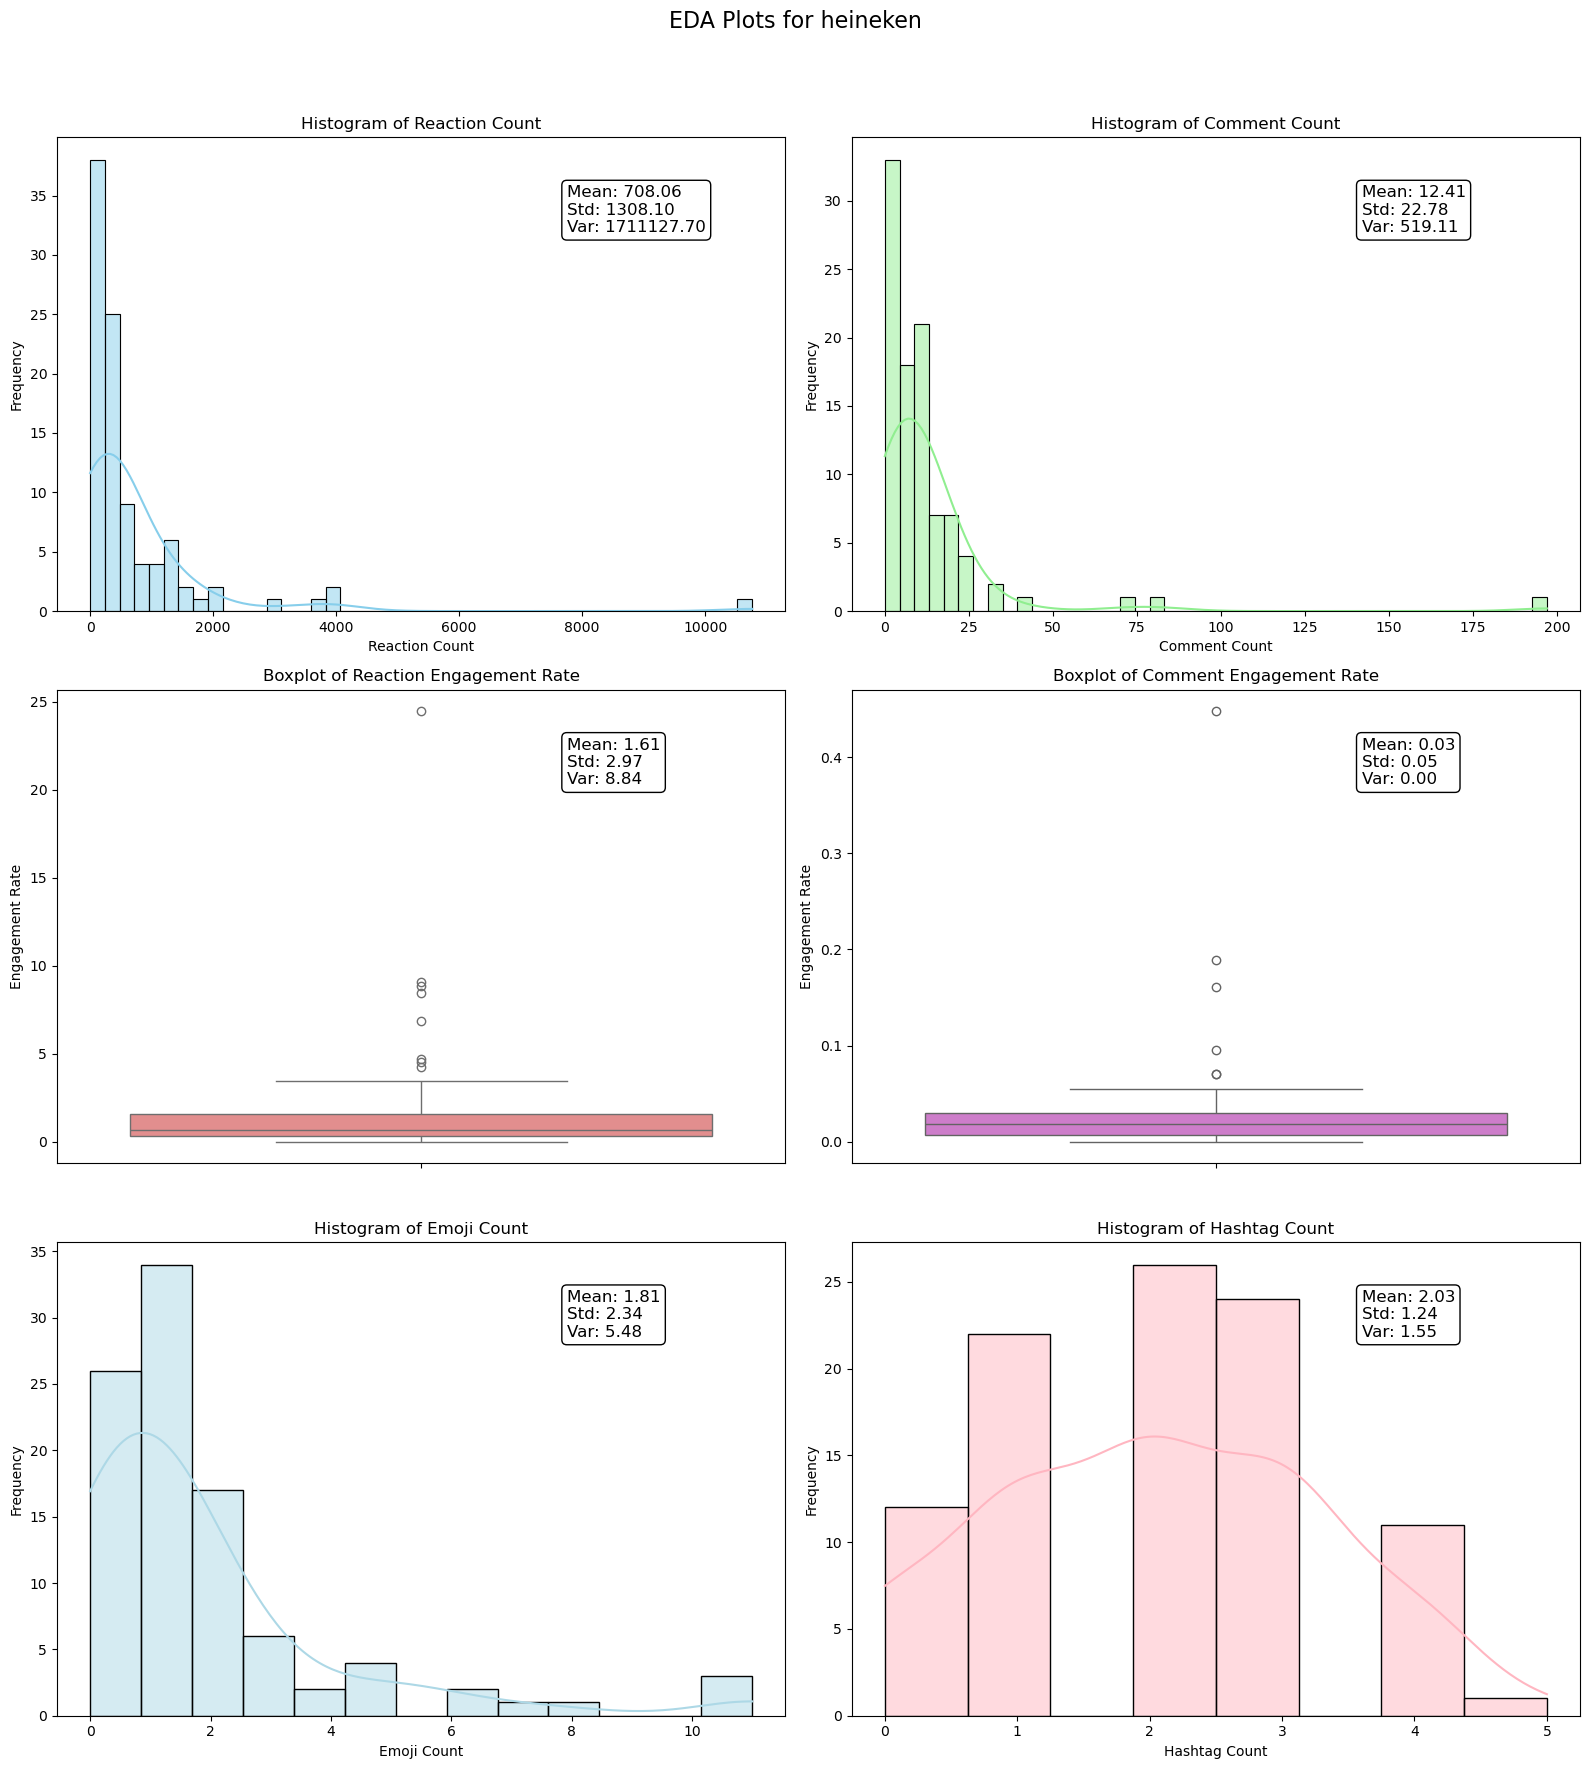

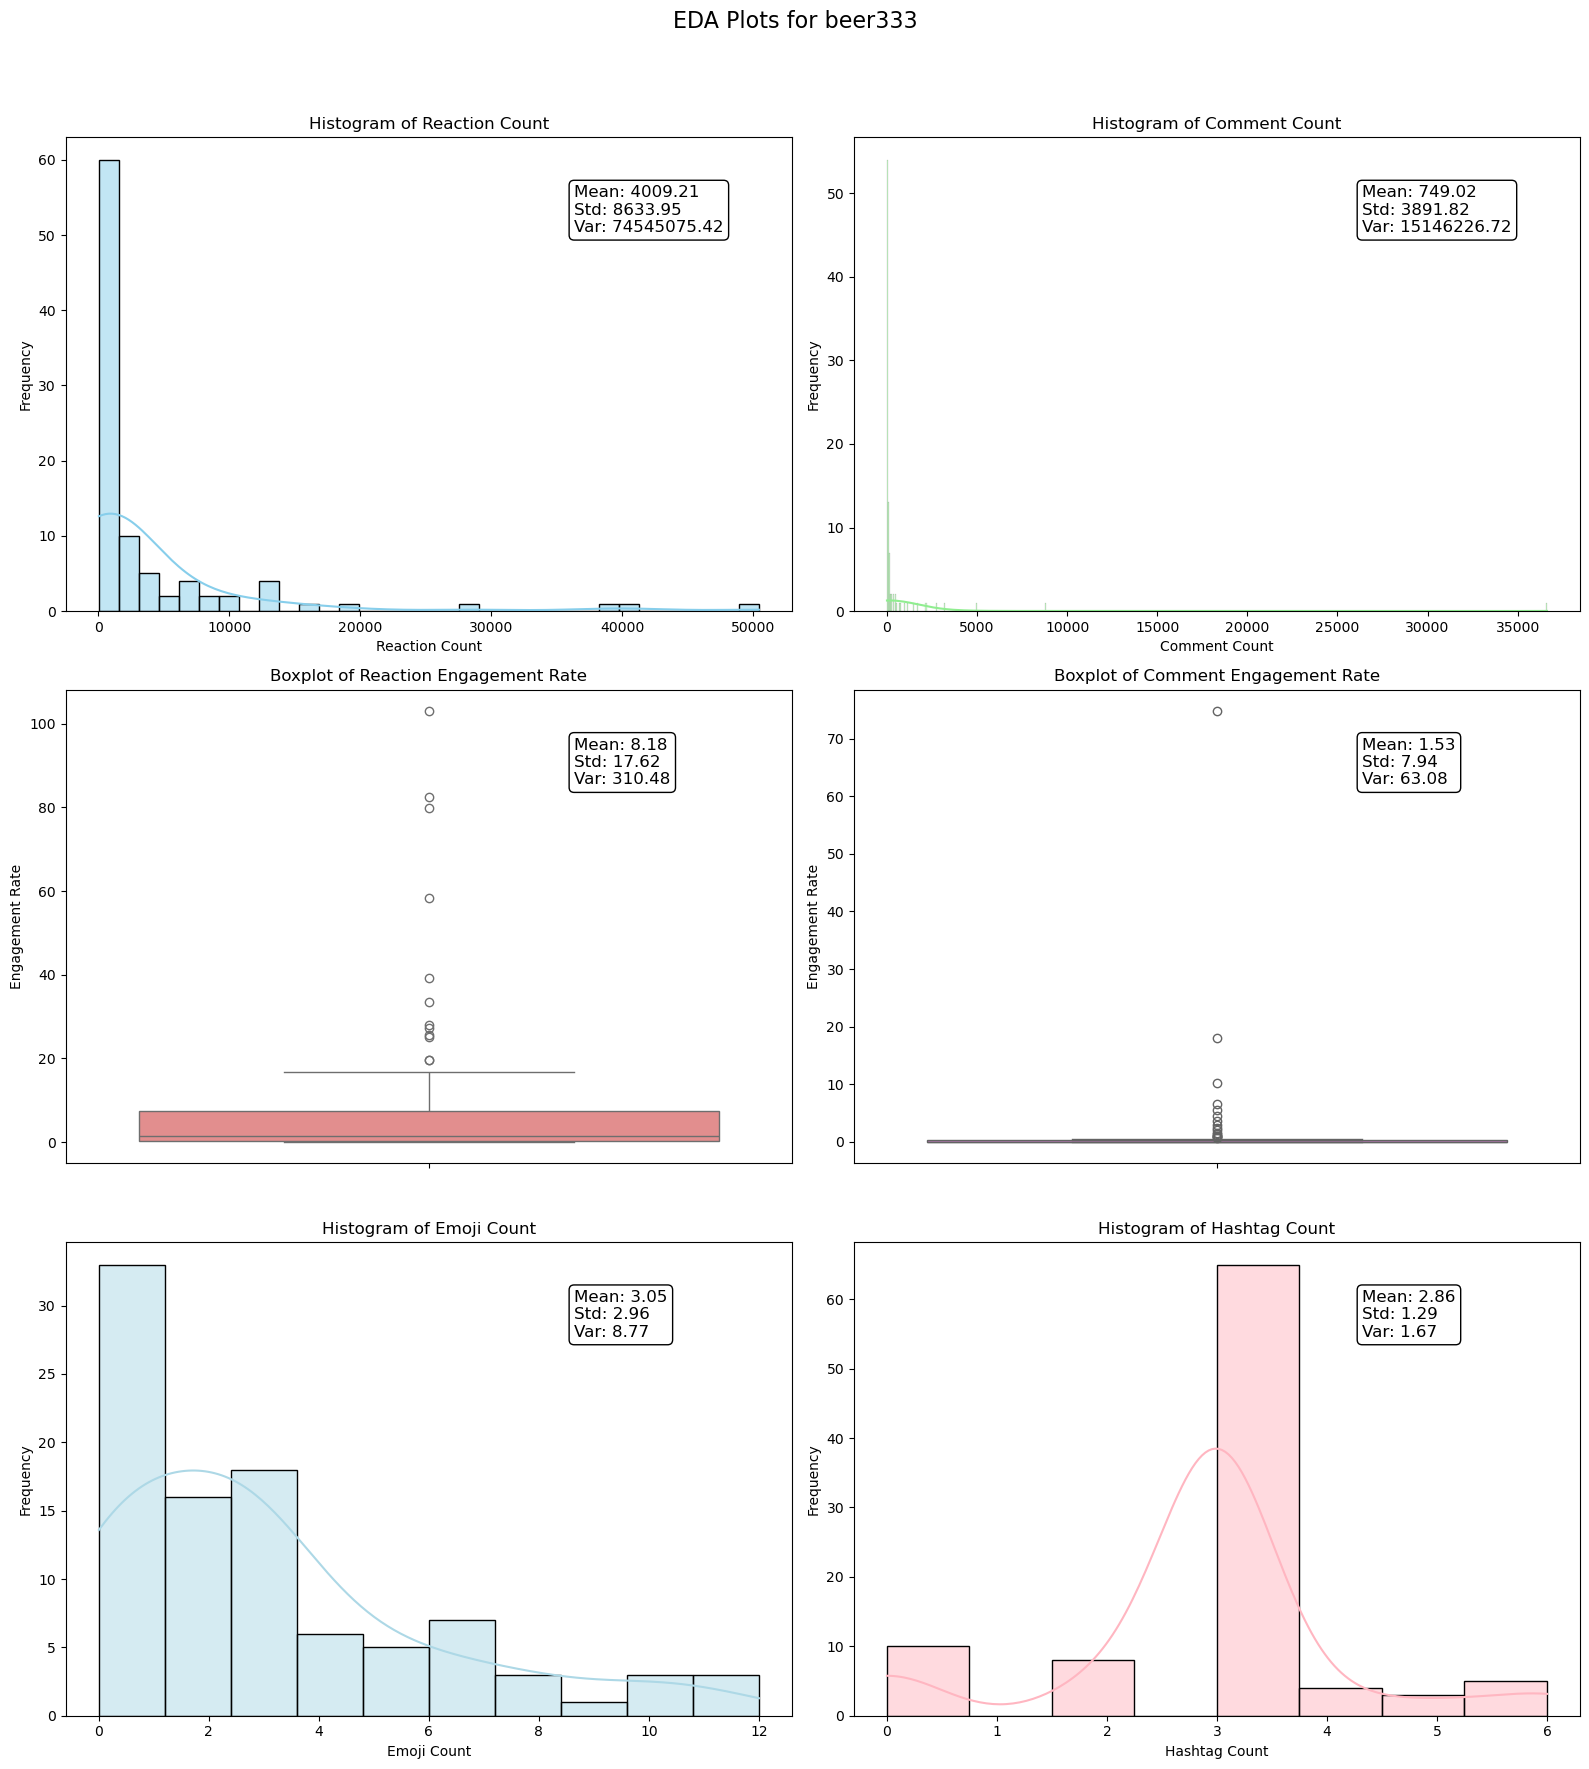

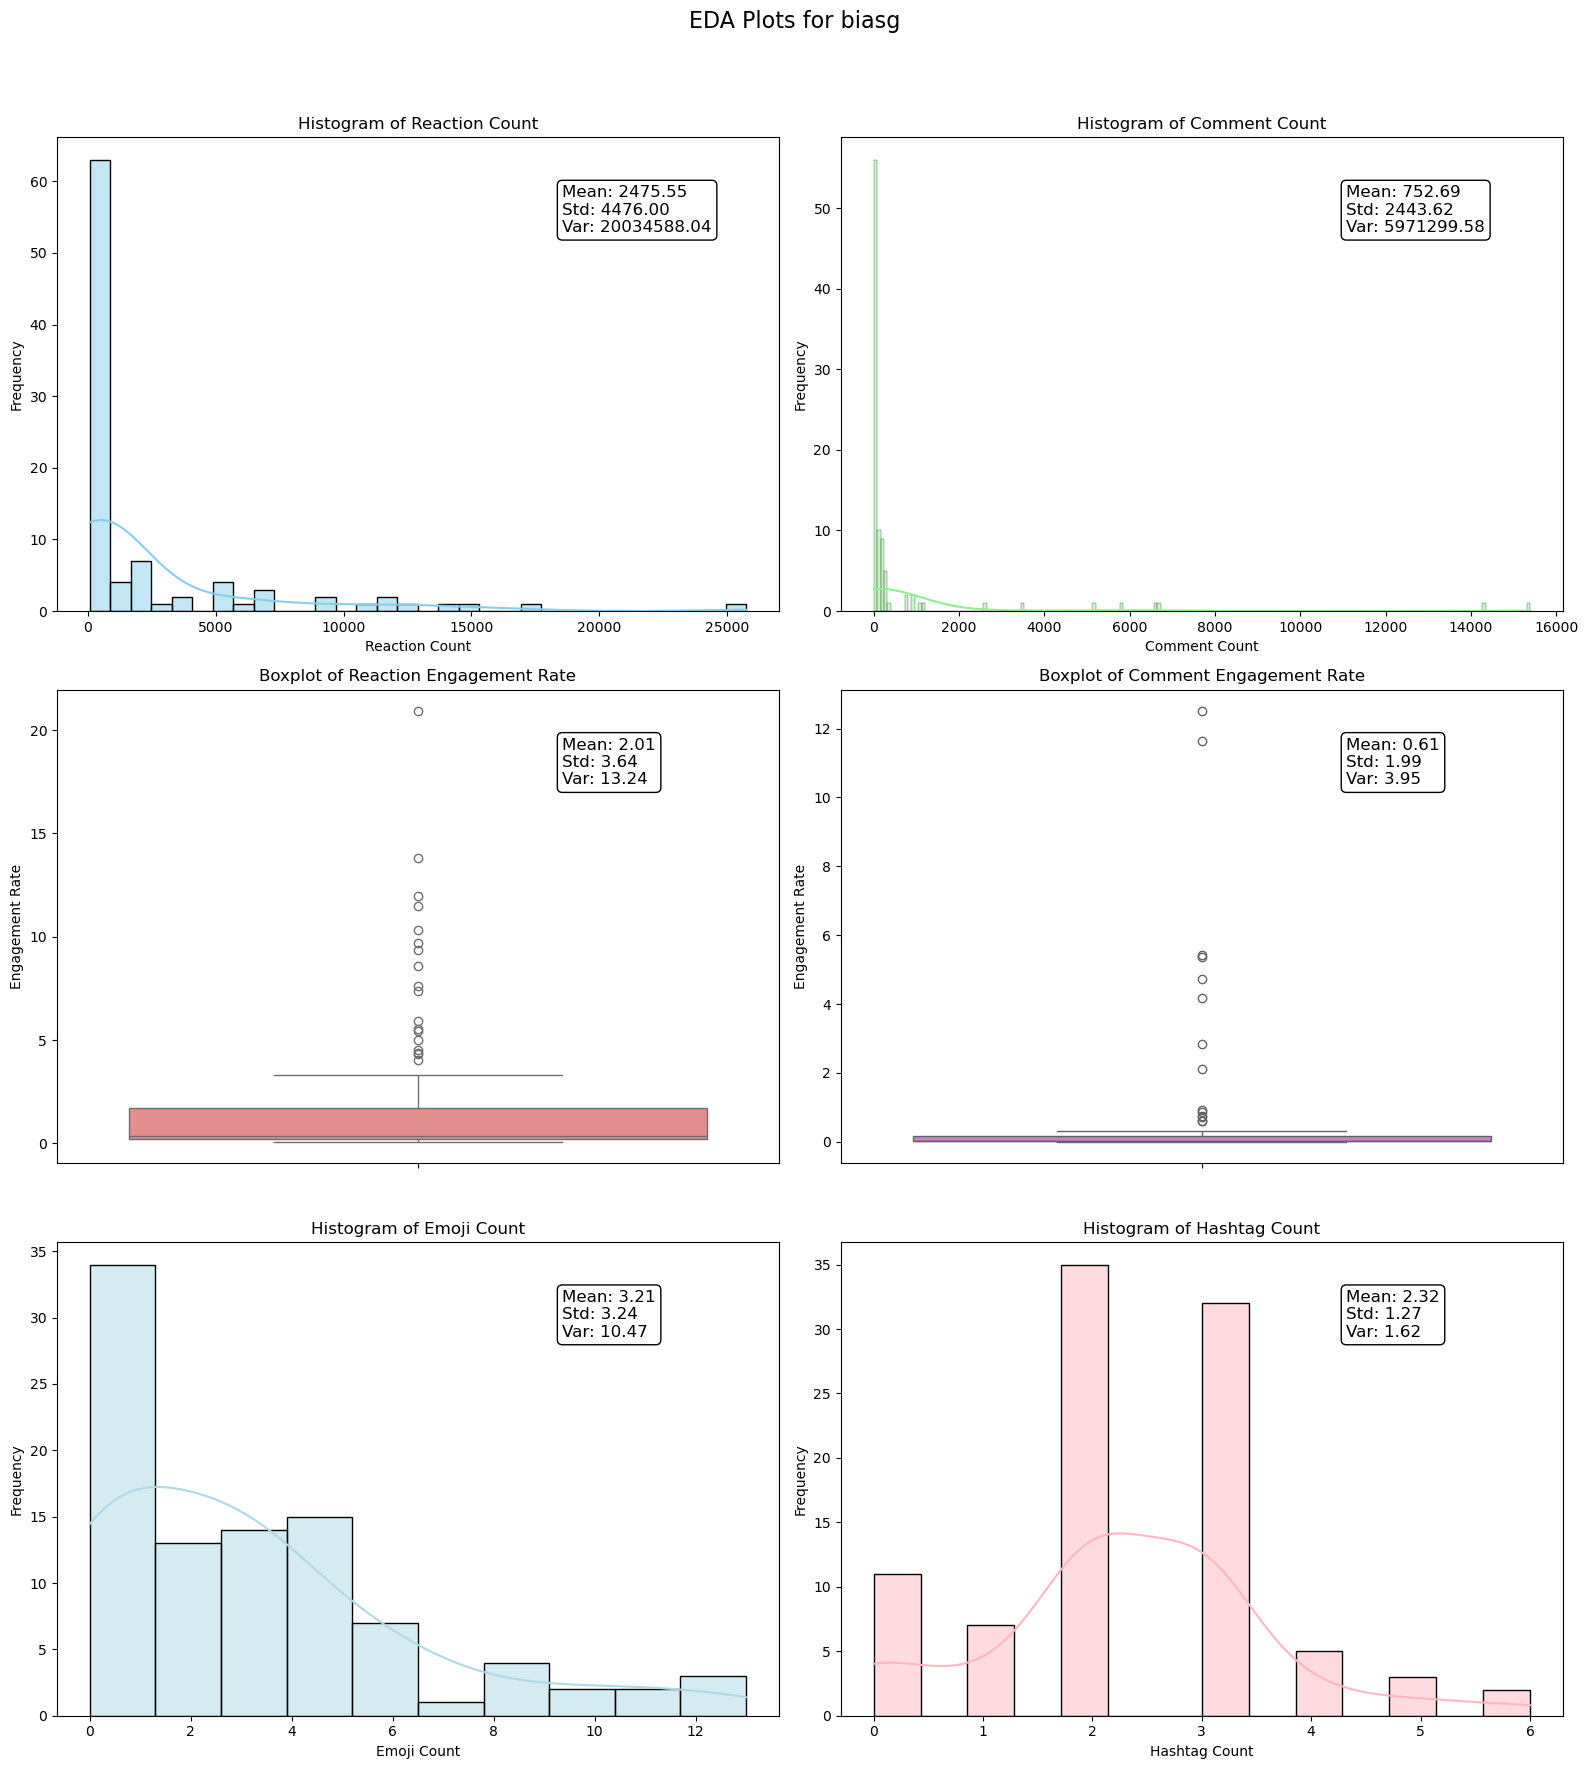

In [881]:
brands = ['heineken', 'beer333', 'biasg']

brand_dfs = {'heineken': heineken, 'beer333': beer333, 'biasg': biasg}
# Loop through each brand in the brands list
for brand_name in brands:
    # Get the corresponding dataframe from brand_dfs dictionary
    brand_df = brand_dfs[brand_name]
    
    # Calculate statistics
    stats = {
        'reaction_count': {
            'mean': brand_df['reaction_count'].mean(),
            'std': brand_df['reaction_count'].std(),
            'var': brand_df['reaction_count'].var()
        },
        'comment_count': {
            'mean': brand_df['comment_count'].mean(),
            'std': brand_df['comment_count'].std(),
            'var': brand_df['comment_count'].var()
        },
        'reaction_engagement_rate': {
            'mean': brand_df['reaction_engagement_rate'].mean(),
            'std': brand_df['reaction_engagement_rate'].std(),
            'var': brand_df['reaction_engagement_rate'].var()
        },
        'comment_engagement_rate': {
            'mean': brand_df['comment_engagement_rate'].mean(),
            'std': brand_df['comment_engagement_rate'].std(),
            'var': brand_df['comment_engagement_rate'].var()
        },
        'emoji_count': {
            'mean': brand_df['emoji_count'].mean(),
            'std': brand_df['emoji_count'].std(),
            'var': brand_df['emoji_count'].var()
        },
        'hashtag_count': {
            'mean': brand_df['hashtag_count'].mean(),
            'std': brand_df['hashtag_count'].std(),
            'var': brand_df['hashtag_count'].var()
        }
    }

    # Create a figure with subplots for each brand
    fig, axes = plt.subplots(3, 2, figsize=(16, 18))
    fig.suptitle(f'EDA Plots for {brand_name}', fontsize=16)
    
    # Histogram and KDE for reaction_count
    sns.histplot(data=brand_df, x='reaction_count', kde=True, color='skyblue', ax=axes[0, 0])
    axes[0, 0].set_title('Histogram of Reaction Count')
    axes[0, 0].set_xlabel('Reaction Count')
    axes[0, 0].set_ylabel('Frequency')
    axes[0, 0].annotate(f"Mean: {stats['reaction_count']['mean']:.2f}\nStd: {stats['reaction_count']['std']:.2f}\nVar: {stats['reaction_count']['var']:.2f}",
                        xy=(0.7, 0.8), xycoords='axes fraction', fontsize=12, bbox=dict(boxstyle="round,pad=0.3", edgecolor='black', facecolor='white'))

    # Histogram and KDE for comment_count
    sns.histplot(data=brand_df, x='comment_count', kde=True, color='lightgreen', ax=axes[0, 1])
    axes[0, 1].set_title('Histogram of Comment Count')
    axes[0, 1].set_xlabel('Comment Count')
    axes[0, 1].set_ylabel('Frequency')
    axes[0, 1].annotate(f"Mean: {stats['comment_count']['mean']:.2f}\nStd: {stats['comment_count']['std']:.2f}\nVar: {stats['comment_count']['var']:.2f}",
                        xy=(0.7, 0.8), xycoords='axes fraction', fontsize=12, bbox=dict(boxstyle="round,pad=0.3", edgecolor='black', facecolor='white'))

    # Boxplot for reaction_engagement_rate
    sns.boxplot(data=brand_df, y='reaction_engagement_rate', color='lightcoral', ax=axes[1, 0])
    axes[1, 0].set_title('Boxplot of Reaction Engagement Rate')
    axes[1, 0].set_ylabel('Engagement Rate')
    axes[1, 0].annotate(f"Mean: {stats['reaction_engagement_rate']['mean']:.2f}\nStd: {stats['reaction_engagement_rate']['std']:.2f}\nVar: {stats['reaction_engagement_rate']['var']:.2f}",
                        xy=(0.7, 0.8), xycoords='axes fraction', fontsize=12, bbox=dict(boxstyle="round,pad=0.3", edgecolor='black', facecolor='white'))

    # Boxplot for comment_engagement_rate
    sns.boxplot(data=brand_df, y='comment_engagement_rate', color='orchid', ax=axes[1, 1])
    axes[1, 1].set_title('Boxplot of Comment Engagement Rate')
    axes[1, 1].set_ylabel('Engagement Rate')
    axes[1, 1].annotate(f"Mean: {stats['comment_engagement_rate']['mean']:.2f}\nStd: {stats['comment_engagement_rate']['std']:.2f}\nVar: {stats['comment_engagement_rate']['var']:.2f}",
                        xy=(0.7, 0.8), xycoords='axes fraction', fontsize=12, bbox=dict(boxstyle="round,pad=0.3", edgecolor='black', facecolor='white'))

    # Histogram and KDE for emoji_count
    sns.histplot(data=brand_df, x='emoji_count', kde=True, color='lightblue', ax=axes[2, 0])
    axes[2, 0].set_title('Histogram of Emoji Count')
    axes[2, 0].set_xlabel('Emoji Count')
    axes[2, 0].set_ylabel('Frequency')
    axes[2, 0].annotate(f"Mean: {stats['emoji_count']['mean']:.2f}\nStd: {stats['emoji_count']['std']:.2f}\nVar: {stats['emoji_count']['var']:.2f}",
                        xy=(0.7, 0.8), xycoords='axes fraction', fontsize=12, bbox=dict(boxstyle="round,pad=0.3", edgecolor='black', facecolor='white'))

    # Histogram and KDE for hashtag_count
    sns.histplot(data=brand_df, x='hashtag_count', kde=True, color='lightpink', ax=axes[2, 1])
    axes[2, 1].set_title('Histogram of Hashtag Count')
    axes[2, 1].set_xlabel('Hashtag Count')
    axes[2, 1].set_ylabel('Frequency')
    axes[2, 1].annotate(f"Mean: {stats['hashtag_count']['mean']:.2f}\nStd: {stats['hashtag_count']['std']:.2f}\nVar: {stats['hashtag_count']['var']:.2f}",
                        xy=(0.7, 0.8), xycoords='axes fraction', fontsize=12, bbox=dict(boxstyle="round,pad=0.3", edgecolor='black', facecolor='white'))

    # Adjust layout for the current figure
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()


**Comments:**

Across the fanpages of Bia Saigon, Heineken, and 333 Beer, a common pattern of **right-skewed distributions** emerges in reactions, comments, emoji usage, and hashtag counts. Most posts receive **low engagement** in terms of reactions and comments, while a few outlier posts, typically those related to **events with rewards**, **minigames**, or **celebrity involvement**, drive higher engagement. This results in a **long tail** in the histograms, reflecting viral content phenomena. **Emoji and hashtag usage** also exhibit similar skewness, with most posts containing **few emojis or hashtags**. The **boxplots confirm the skewed nature** of engagement, with **median engagement** being low, but a few outliers significantly pull the mean upward. Optimizing content strategies to leverage these high-engagement posts could enhance overall interaction rates across these fanpages. Due to the **prevalence of outliers** in the dataset, the reliability of the analysis has been compromised. These outliers significantly skew the results, affecting the overall accuracy of the test. To **enhance the reliability** of the further analysis, a decision has been made to **exclude certain outliers**. The team developed a new function to systematically remove outliers and enhance the accuracy of the analysis, as follow.

In [882]:
def remove_outliers(df, columns):
    # Loop through each column specified
    for column in columns:
        # Calculate the IQR (Interquartile Range)
        Q1 = df[column].quantile(0.25)
        Q3 = df[column].quantile(0.75)
        IQR = Q3 - Q1

        # Define the outlier thresholds
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR

        # Remove outliers outside the IQR range
        df = df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]
    
    return df

# Specify the columns to remove outliers from
columns_to_check = ['reaction_engagement_rate', 'comment_engagement_rate']

# Apply the function to each dataframe
heineken = remove_outliers(heineken, columns_to_check)
beer333 = remove_outliers(beer333, columns_to_check)
biasg = remove_outliers(biasg, columns_to_check)

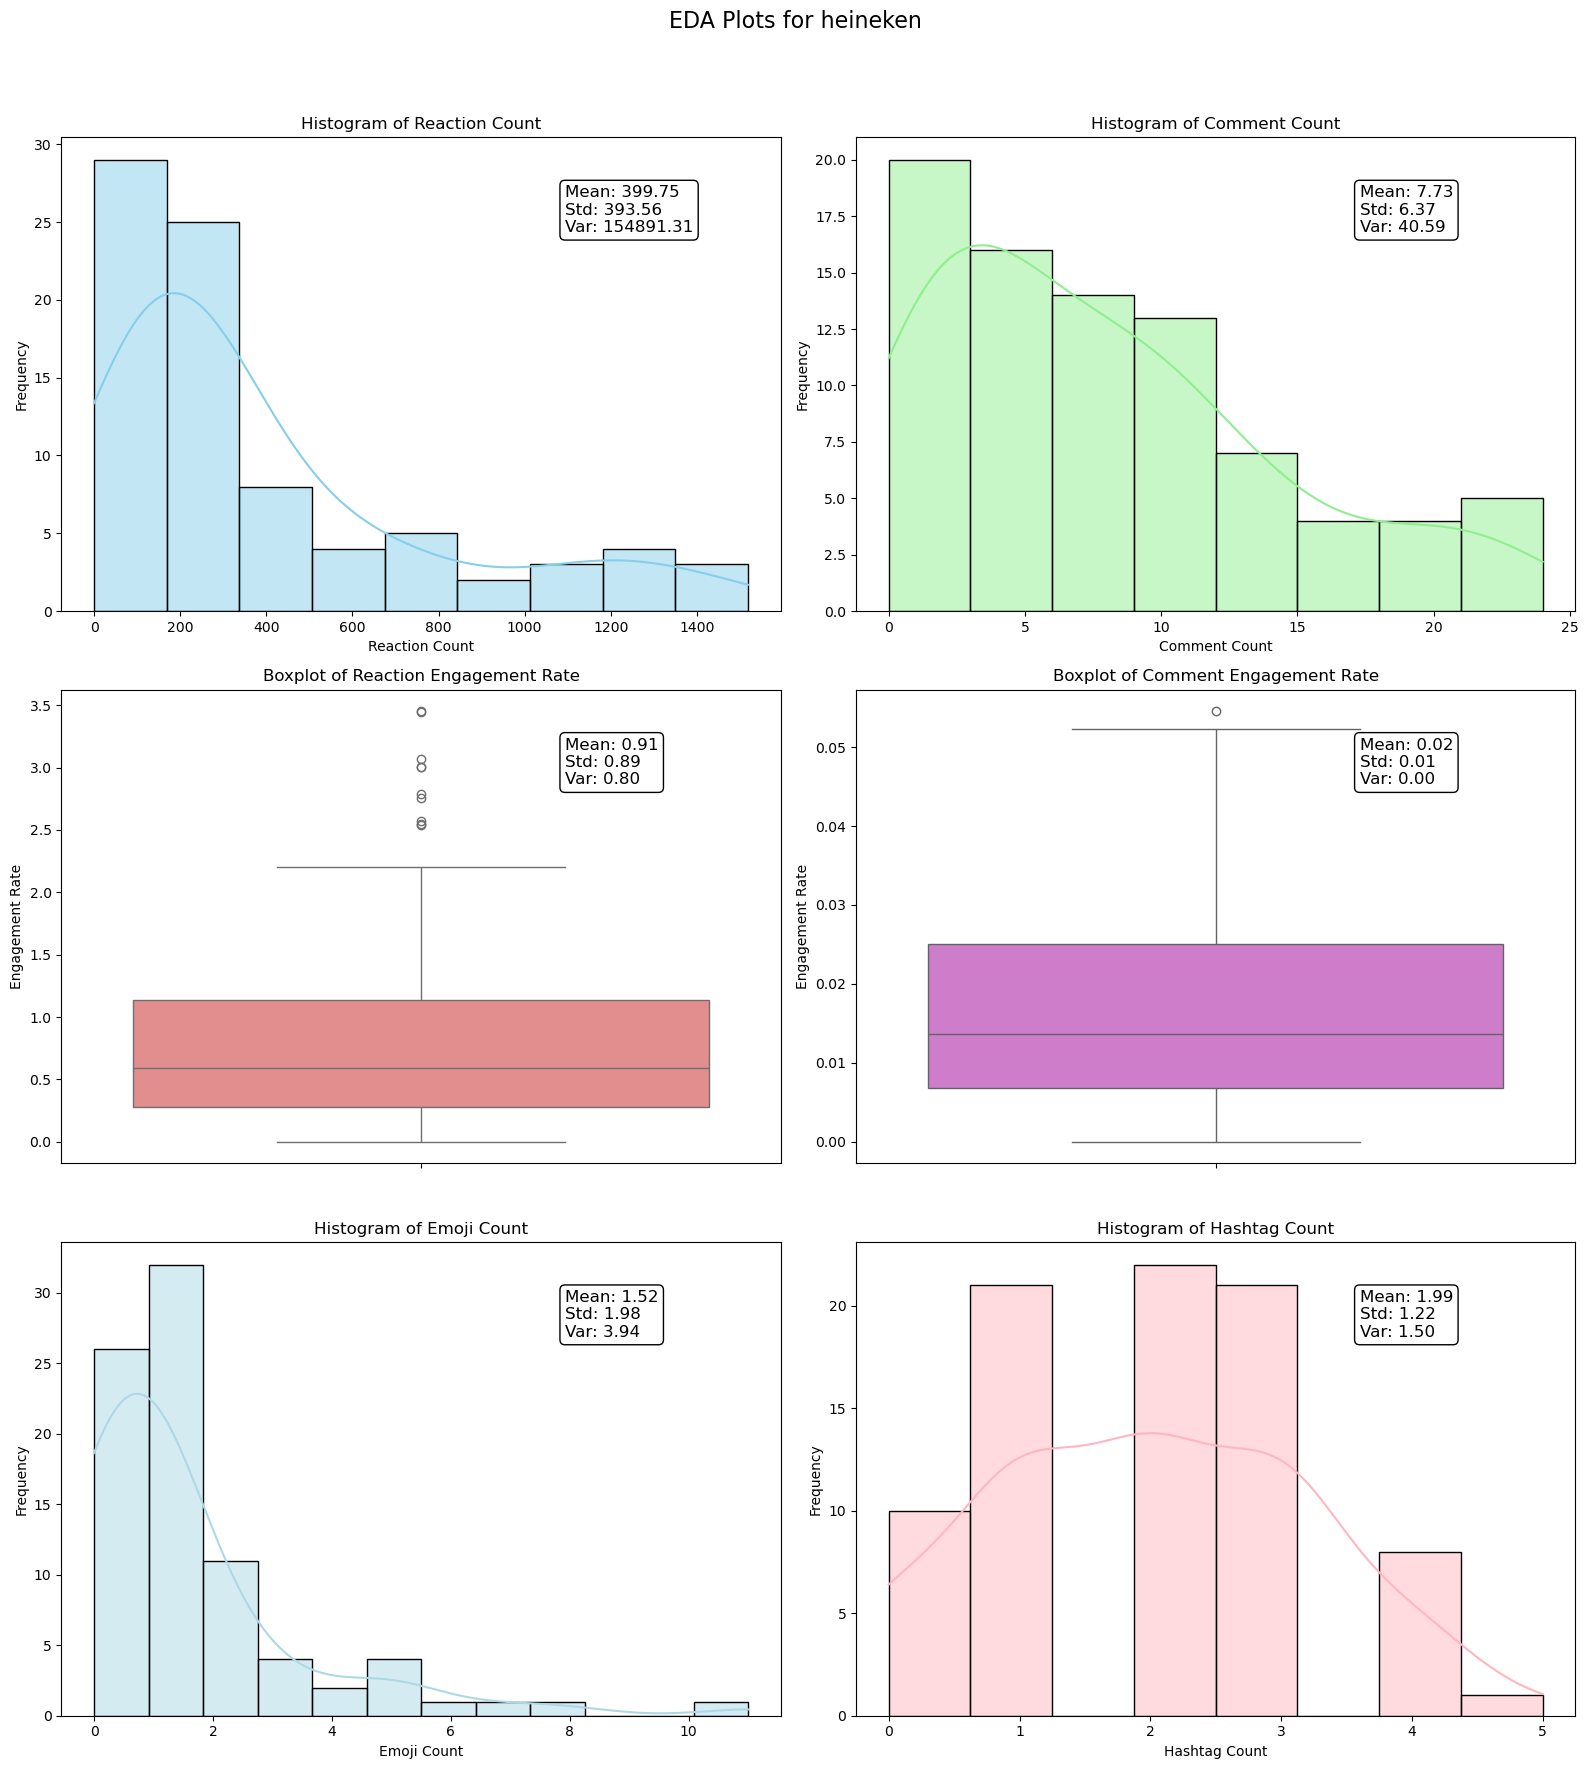

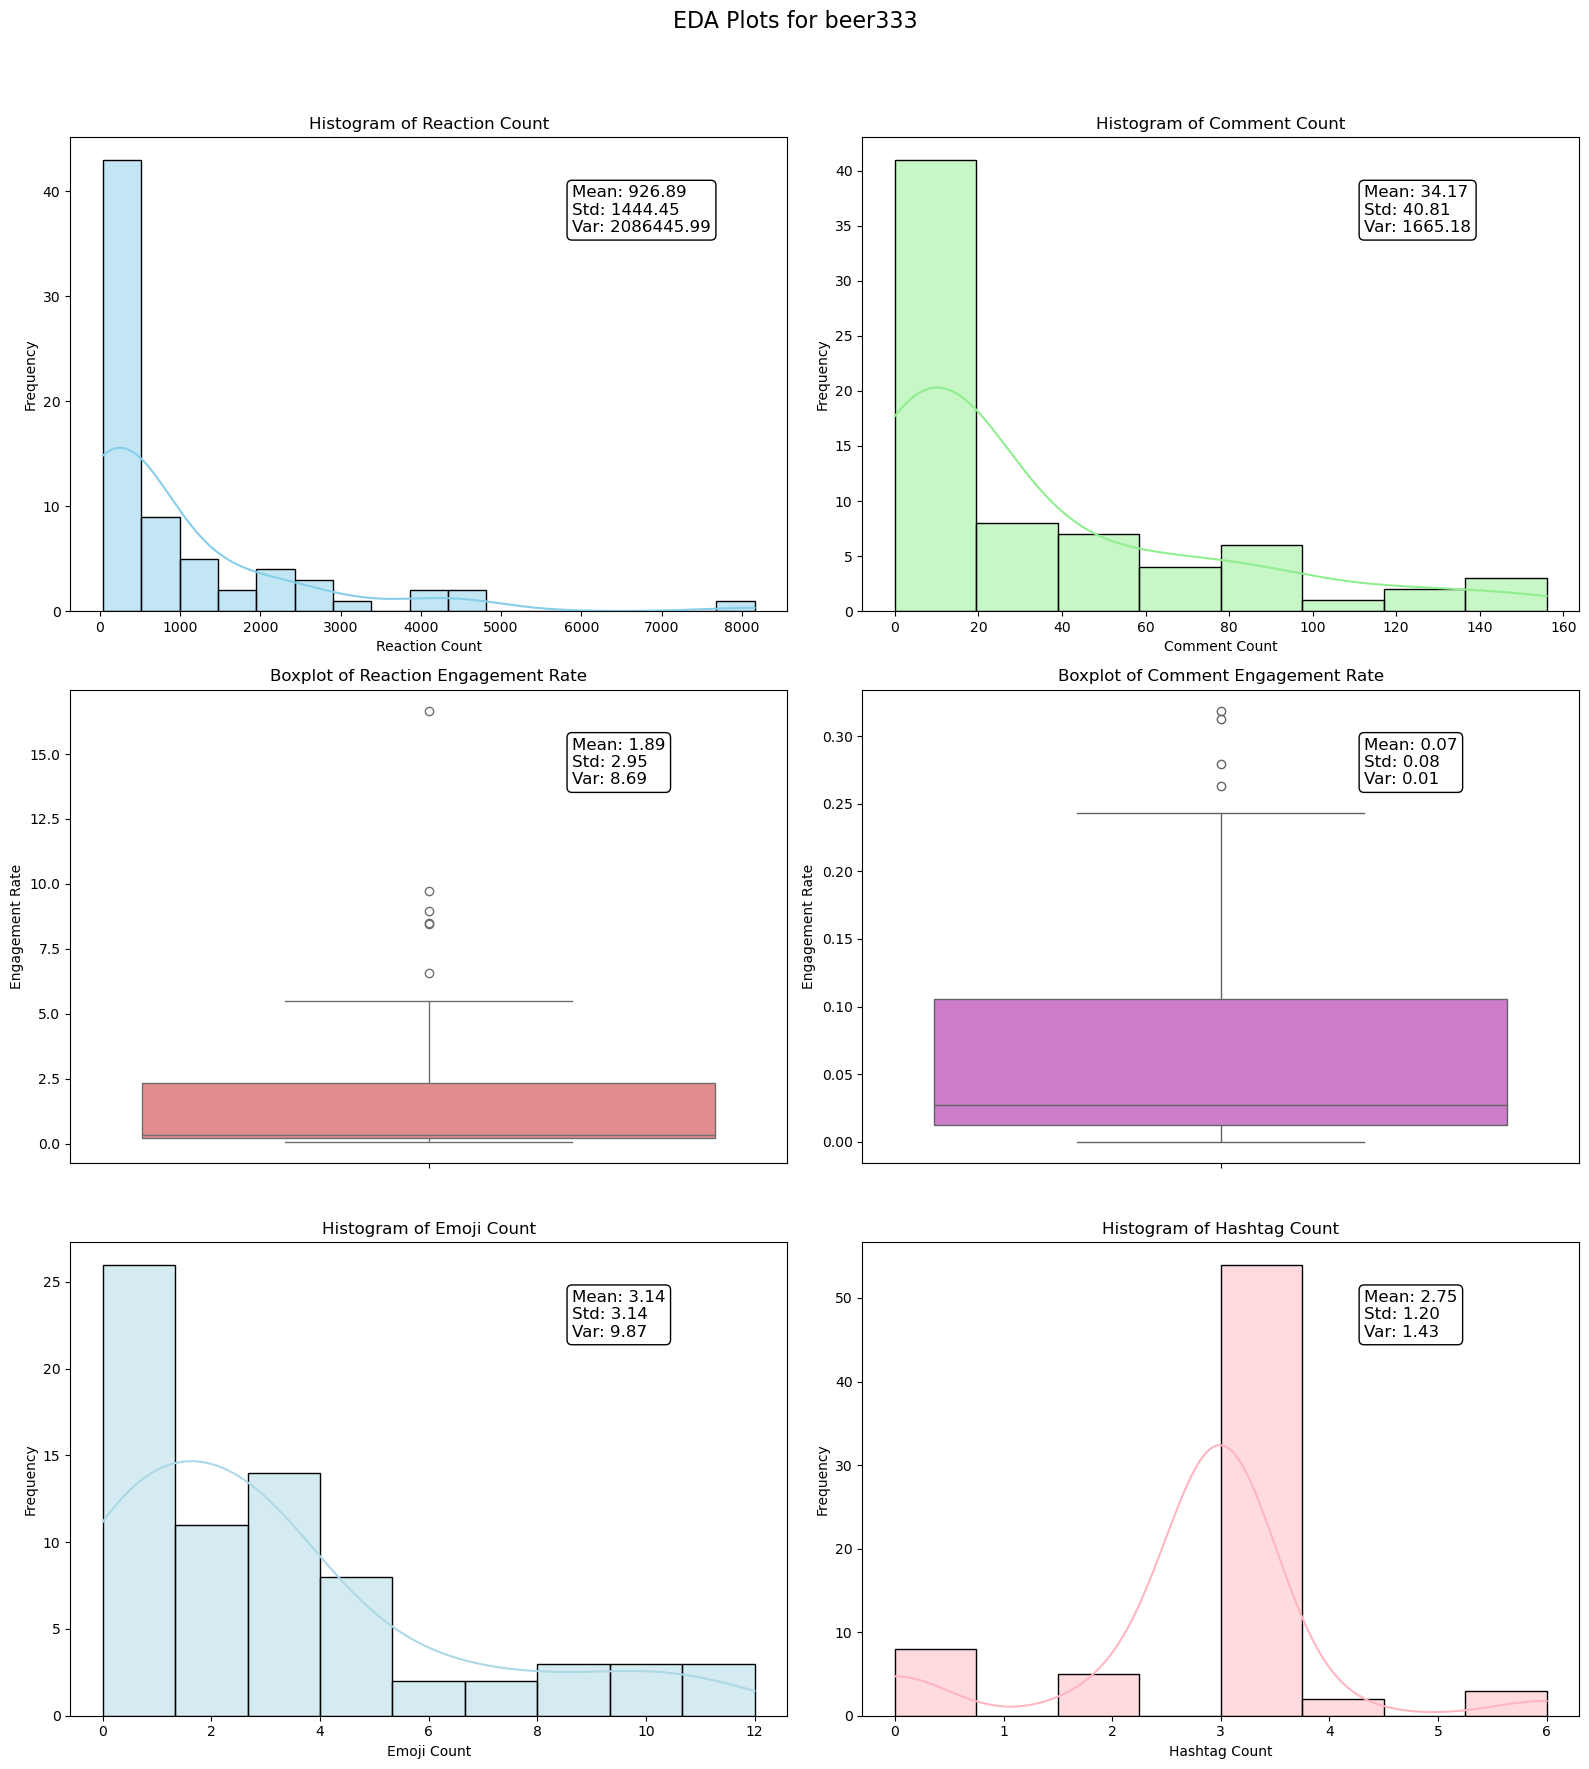

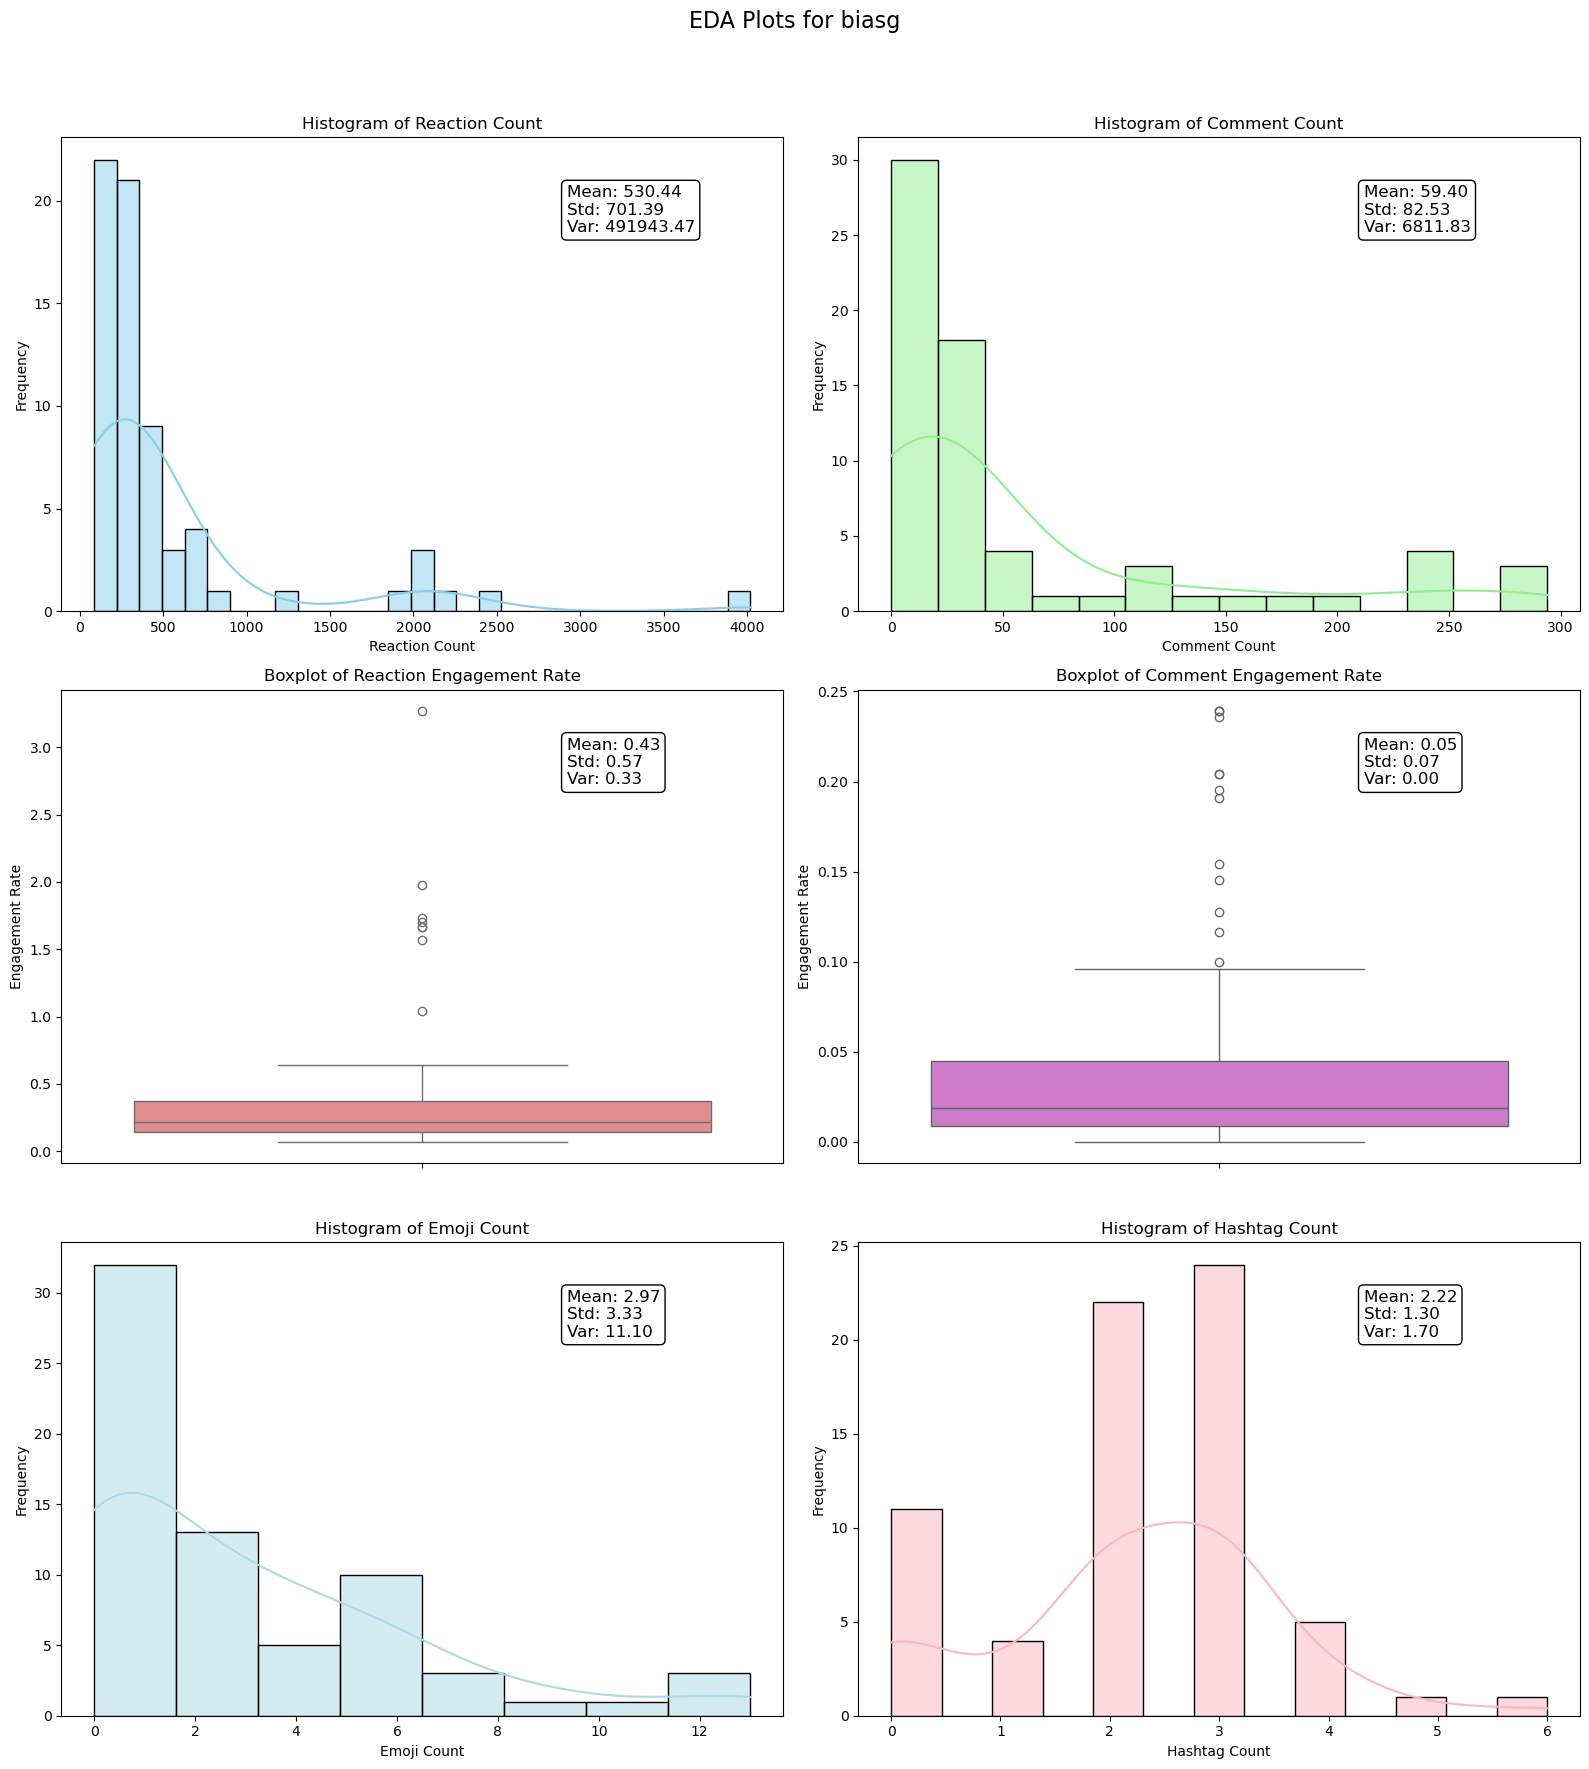

In [883]:
brands = ['heineken', 'beer333', 'biasg']

brand_dfs = {'heineken': heineken, 'beer333': beer333, 'biasg': biasg}
# Loop through each brand in the brands list
for brand_name in brands:
    # Get the corresponding dataframe from brand_dfs dictionary
    brand_df = brand_dfs[brand_name]
    
    # Calculate statistics
    stats = {
        'reaction_count': {
            'mean': brand_df['reaction_count'].mean(),
            'std': brand_df['reaction_count'].std(),
            'var': brand_df['reaction_count'].var()
        },
        'comment_count': {
            'mean': brand_df['comment_count'].mean(),
            'std': brand_df['comment_count'].std(),
            'var': brand_df['comment_count'].var()
        },
        'reaction_engagement_rate': {
            'mean': brand_df['reaction_engagement_rate'].mean(),
            'std': brand_df['reaction_engagement_rate'].std(),
            'var': brand_df['reaction_engagement_rate'].var()
        },
        'comment_engagement_rate': {
            'mean': brand_df['comment_engagement_rate'].mean(),
            'std': brand_df['comment_engagement_rate'].std(),
            'var': brand_df['comment_engagement_rate'].var()
        },
        'emoji_count': {
            'mean': brand_df['emoji_count'].mean(),
            'std': brand_df['emoji_count'].std(),
            'var': brand_df['emoji_count'].var()
        },
        'hashtag_count': {
            'mean': brand_df['hashtag_count'].mean(),
            'std': brand_df['hashtag_count'].std(),
            'var': brand_df['hashtag_count'].var()
        }
    }

    # Create a figure with subplots for each brand
    fig, axes = plt.subplots(3, 2, figsize=(16, 18))
    fig.suptitle(f'EDA Plots for {brand_name}', fontsize=16)
    
    # Histogram and KDE for reaction_count
    sns.histplot(data=brand_df, x='reaction_count', kde=True, color='skyblue', ax=axes[0, 0])
    axes[0, 0].set_title('Histogram of Reaction Count')
    axes[0, 0].set_xlabel('Reaction Count')
    axes[0, 0].set_ylabel('Frequency')
    axes[0, 0].annotate(f"Mean: {stats['reaction_count']['mean']:.2f}\nStd: {stats['reaction_count']['std']:.2f}\nVar: {stats['reaction_count']['var']:.2f}",
                        xy=(0.7, 0.8), xycoords='axes fraction', fontsize=12, bbox=dict(boxstyle="round,pad=0.3", edgecolor='black', facecolor='white'))

    # Histogram and KDE for comment_count
    sns.histplot(data=brand_df, x='comment_count', kde=True, color='lightgreen', ax=axes[0, 1])
    axes[0, 1].set_title('Histogram of Comment Count')
    axes[0, 1].set_xlabel('Comment Count')
    axes[0, 1].set_ylabel('Frequency')
    axes[0, 1].annotate(f"Mean: {stats['comment_count']['mean']:.2f}\nStd: {stats['comment_count']['std']:.2f}\nVar: {stats['comment_count']['var']:.2f}",
                        xy=(0.7, 0.8), xycoords='axes fraction', fontsize=12, bbox=dict(boxstyle="round,pad=0.3", edgecolor='black', facecolor='white'))

    # Boxplot for reaction_engagement_rate
    sns.boxplot(data=brand_df, y='reaction_engagement_rate', color='lightcoral', ax=axes[1, 0])
    axes[1, 0].set_title('Boxplot of Reaction Engagement Rate')
    axes[1, 0].set_ylabel('Engagement Rate')
    axes[1, 0].annotate(f"Mean: {stats['reaction_engagement_rate']['mean']:.2f}\nStd: {stats['reaction_engagement_rate']['std']:.2f}\nVar: {stats['reaction_engagement_rate']['var']:.2f}",
                        xy=(0.7, 0.8), xycoords='axes fraction', fontsize=12, bbox=dict(boxstyle="round,pad=0.3", edgecolor='black', facecolor='white'))

    # Boxplot for comment_engagement_rate
    sns.boxplot(data=brand_df, y='comment_engagement_rate', color='orchid', ax=axes[1, 1])
    axes[1, 1].set_title('Boxplot of Comment Engagement Rate')
    axes[1, 1].set_ylabel('Engagement Rate')
    axes[1, 1].annotate(f"Mean: {stats['comment_engagement_rate']['mean']:.2f}\nStd: {stats['comment_engagement_rate']['std']:.2f}\nVar: {stats['comment_engagement_rate']['var']:.2f}",
                        xy=(0.7, 0.8), xycoords='axes fraction', fontsize=12, bbox=dict(boxstyle="round,pad=0.3", edgecolor='black', facecolor='white'))

    # Histogram and KDE for emoji_count
    sns.histplot(data=brand_df, x='emoji_count', kde=True, color='lightblue', ax=axes[2, 0])
    axes[2, 0].set_title('Histogram of Emoji Count')
    axes[2, 0].set_xlabel('Emoji Count')
    axes[2, 0].set_ylabel('Frequency')
    axes[2, 0].annotate(f"Mean: {stats['emoji_count']['mean']:.2f}\nStd: {stats['emoji_count']['std']:.2f}\nVar: {stats['emoji_count']['var']:.2f}",
                        xy=(0.7, 0.8), xycoords='axes fraction', fontsize=12, bbox=dict(boxstyle="round,pad=0.3", edgecolor='black', facecolor='white'))

    # Histogram and KDE for hashtag_count
    sns.histplot(data=brand_df, x='hashtag_count', kde=True, color='lightpink', ax=axes[2, 1])
    axes[2, 1].set_title('Histogram of Hashtag Count')
    axes[2, 1].set_xlabel('Hashtag Count')
    axes[2, 1].set_ylabel('Frequency')
    axes[2, 1].annotate(f"Mean: {stats['hashtag_count']['mean']:.2f}\nStd: {stats['hashtag_count']['std']:.2f}\nVar: {stats['hashtag_count']['var']:.2f}",
                        xy=(0.7, 0.8), xycoords='axes fraction', fontsize=12, bbox=dict(boxstyle="round,pad=0.3", edgecolor='black', facecolor='white'))

    # Adjust layout for the current figure
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()


**Comment:** 

After removing outliers, the trends indicated more **consistent and moderate engagement rates**. After the outliers were removed, the distribution of data is easier to interpret yet, it the removal does not affect much the pattern of the dataset. The distribution of Heineken, Beer333, and Biasg shows that all three companies exhibit right-skewed distributions in their "Reaction Count" and "Comment Count," with the majority of reactions and comments concentrated in the lower ranges and occasional outliers with significantly higher values. Heineken's average reaction count is around 400, Beer333's is around 927, and Biasg's is around 530, with moderate to high variability in each case. Comment counts follow similar trends, with Heineken averaging 8 comments, Beer333 averaging 34, and Biasg averaging 59. **Engagement rates for reactions and comments are generally low across the board**, with Heineken's reaction engagement rate at 0.91, Beer333's at 1.89, and Biasg's at 0.43, while comment engagement rates are particularly low for all three companies, averaging around 0.05 to 0.07. This **low engagement rate can be attributed to several factors**: First, the overall nature of the content might not drive high engagement, as some posts might focus more on delivering information rather than encouraging interaction. Second, there may be a lack of active audience participation, especially if the posts are not tailored to provoke reactions or comments. Lastly, the platform algorithms may play a role, where the posts aren't getting as much visibility, leading to fewer engagements. Emoji and hashtag usage is minimal for all three companies, with most posts using 0 to 3 emojis and 1 to 3 hashtags. Despite the occasional outliers, overall emoji and hashtag usage remains low, indicating that these elements are not a primary focus in content strategy. 

### 4.2. Descriptive statistics for date features

In [884]:
start_date = pd.Timestamp('2024-01-01')
end_date = pd.Timestamp.now()
heineken = heineken[(heineken['date'] >= start_date) & (heineken['date'] <= end_date)]
beer333 = beer333[(beer333['date'] >= start_date) & (beer333['date'] <= end_date)]
biasg = biasg[(biasg['date'] >= start_date) & (biasg['date'] <= end_date)]

**Explanation of using data solely in 2024:** Social media environments and user behavior change quickly, and trends in how users interact with posts evolve over time. Including older data, such as posts from 2022 in the Heineken dataset, might reflect outdated patterns that no longer apply. By focusing on posts from 2024, the model can accurately reflects current user behavior and provides relevant insights. Additionally, factors that influence engagement, like events and marketing campaigns, vary year to year. By using only data from 2024, it can avoid skewing the model with data from past events and strategies, leading to more accurate and consistent predictions for this year’s posts.

In [885]:
# Function to clean emojis by removing unwanted characters
def clean_emojis(emojis):
    if emojis:
        emoji_pattern = r'[\U0001F600-\U0001F64F\U0001F300-\U0001F5FF\U0001F680-\U0001F6FF\U0001F700-\U0001F77F\U0001F780-\U0001F7FF\U0001F800-\U0001F8FF\U0001F900-\U0001F9FF\U0001FA00-\U0001FA6F\U0001FA70-\U0001FAFF\u2728]'
        cleaned_emojis = ''.join(re.findall(emoji_pattern, emojis))
        return cleaned_emojis if cleaned_emojis else None
    return None
# Function to parse dates and handle missing years
def parse_date(date_str):
    if isinstance(date_str, pd.Timestamp):
        return date_str  # If it's already a timestamp, return as is
    if pd.isna(date_str) or not isinstance(date_str, str) or not date_str.strip():
        return pd.NaT

    date_str = date_str.strip()
    current_year = datetime.now().year
    
    # Attempt to parse with the assumption of missing year
    try:
        return datetime.strptime(f"{date_str} {current_year}", "%d tháng %m lúc %H:%M %Y")
    except ValueError:
        # Handle cases where the year is included
        try:
            return datetime.strptime(date_str, "%d tháng %m, %Y lúc %H:%M")
        except ValueError:
            return pd.NaT

# Function to format the post data
def format_post_data(df):
    # Clean emojis in the 'emojis' column
    df['emojis'] = df['emojis'].apply(clean_emojis)
    
    # Parse the 'date' column
    df['date'] = df['date'].apply(parse_date)
    
    return df

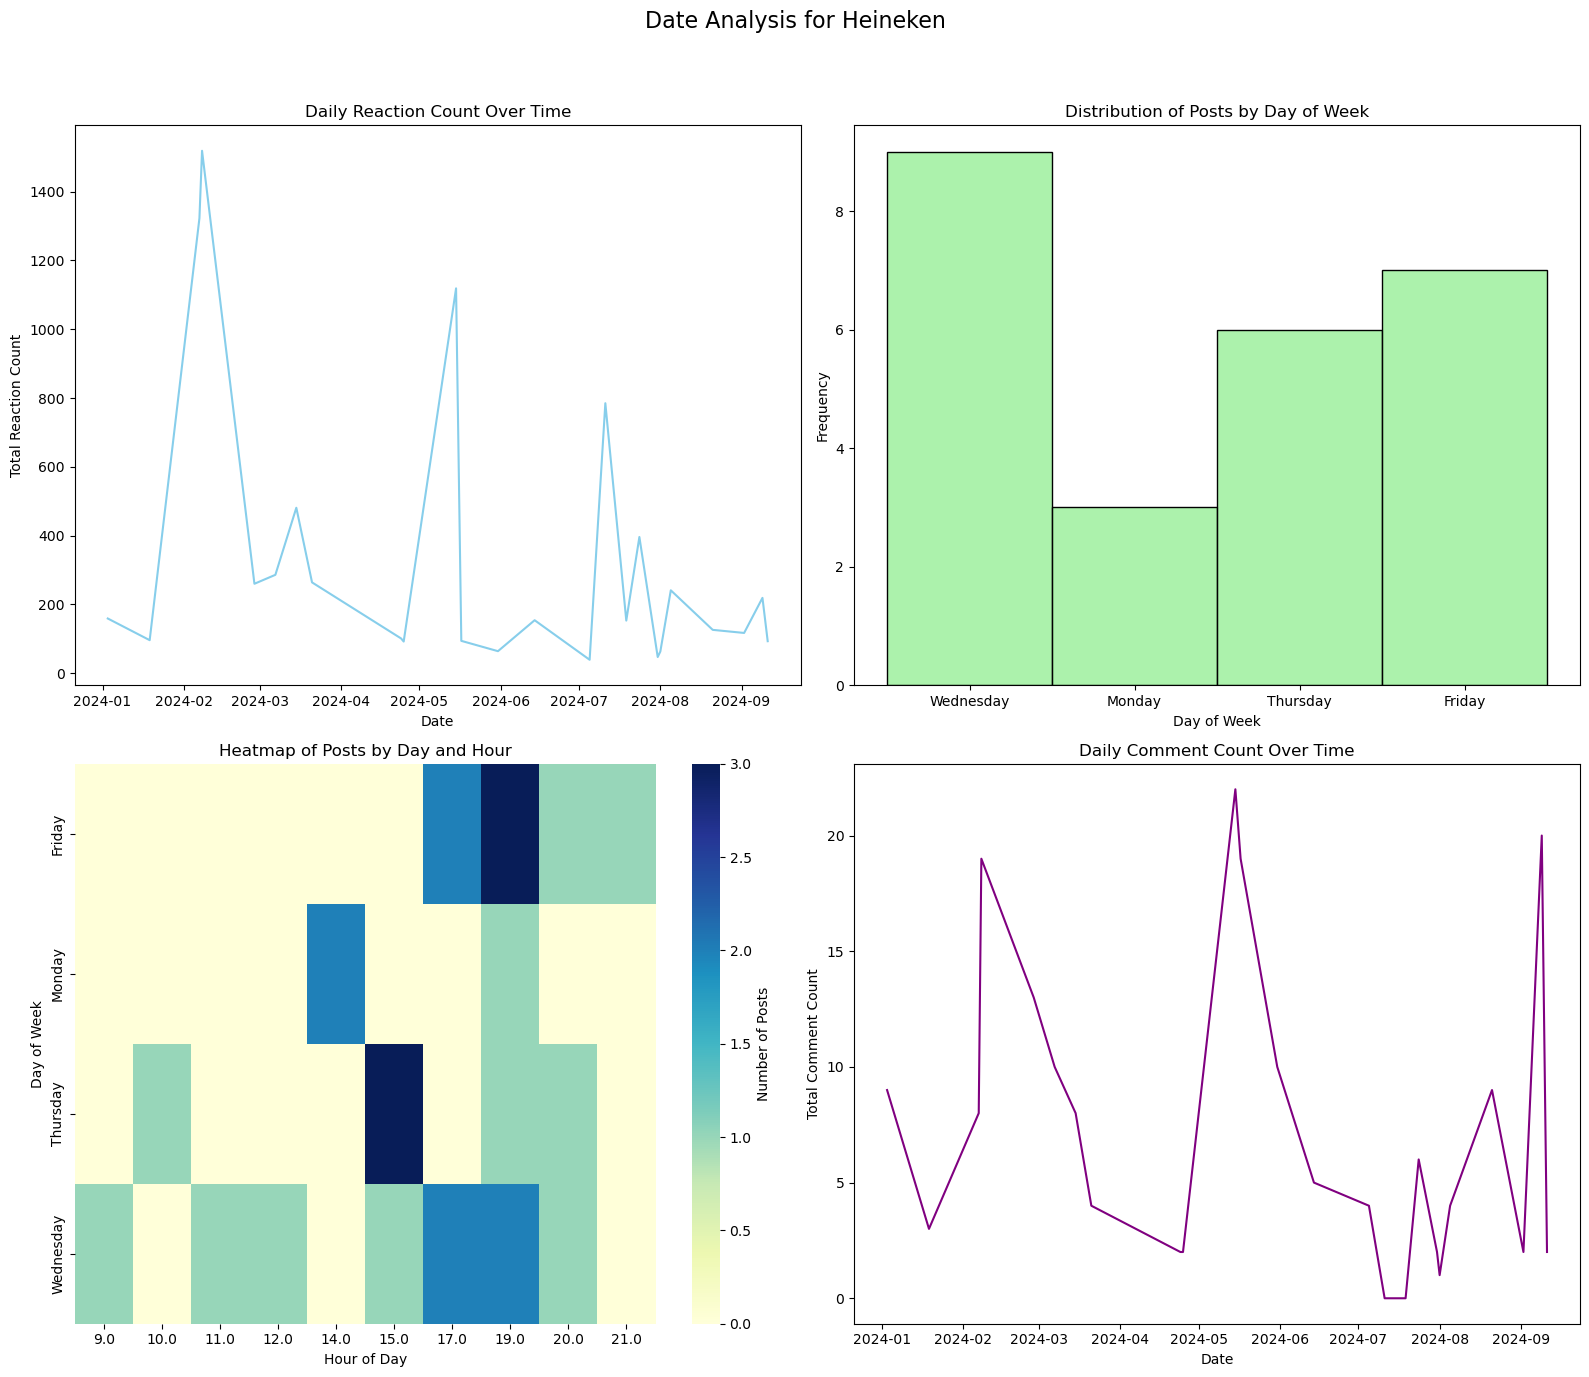

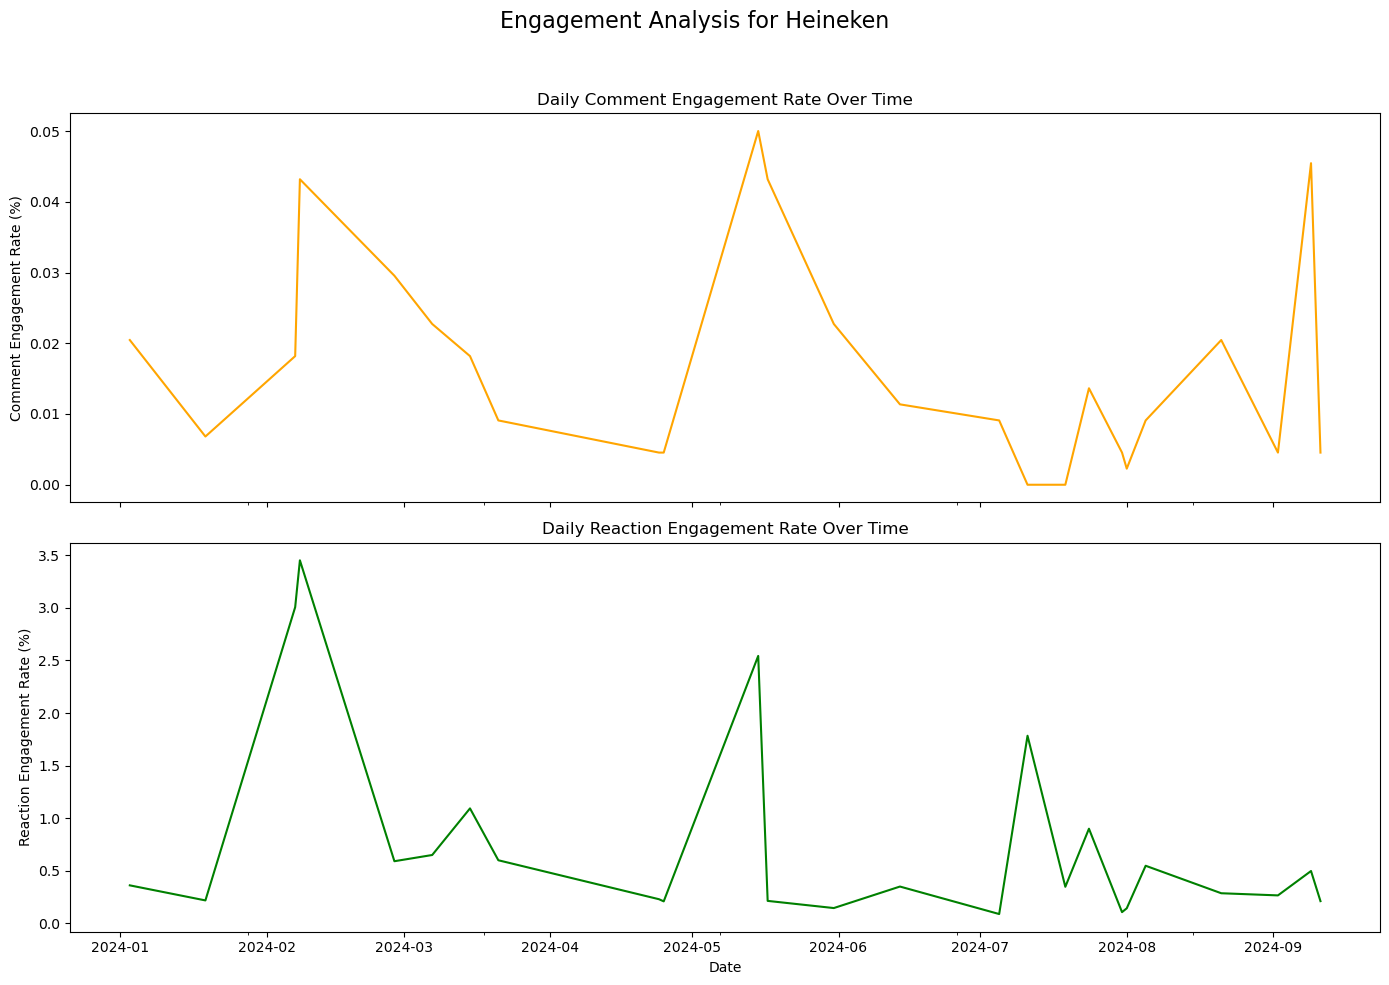

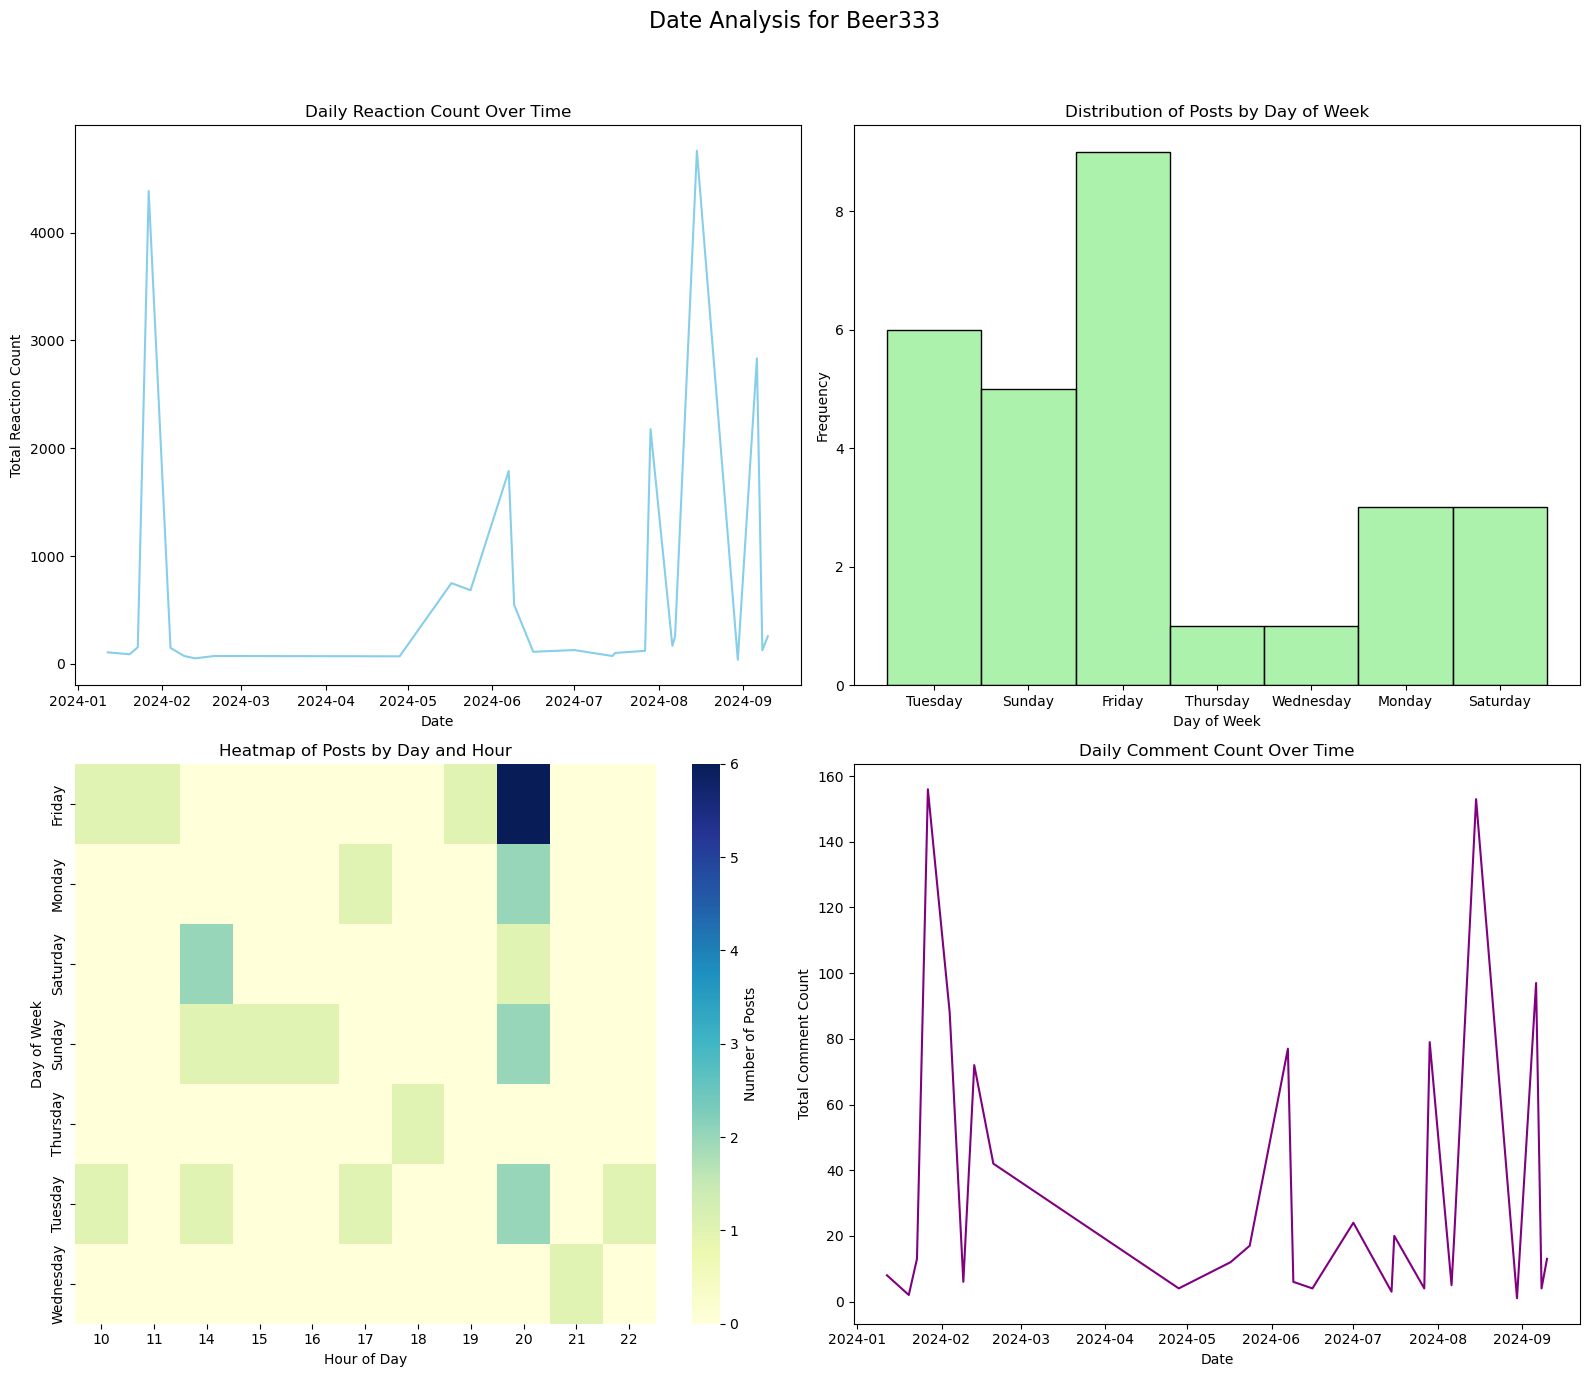

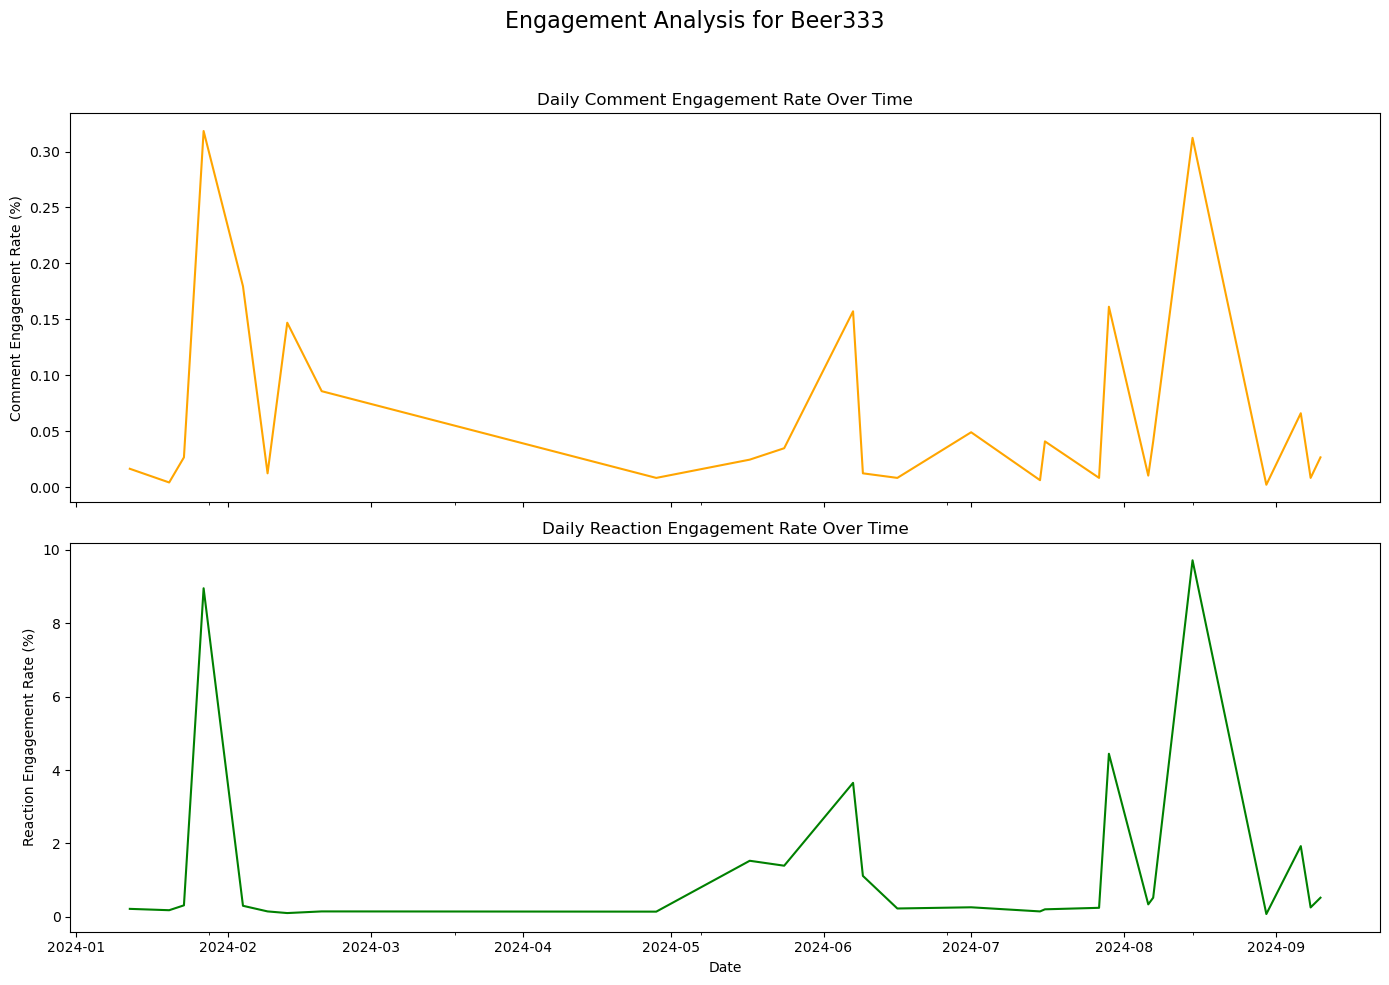

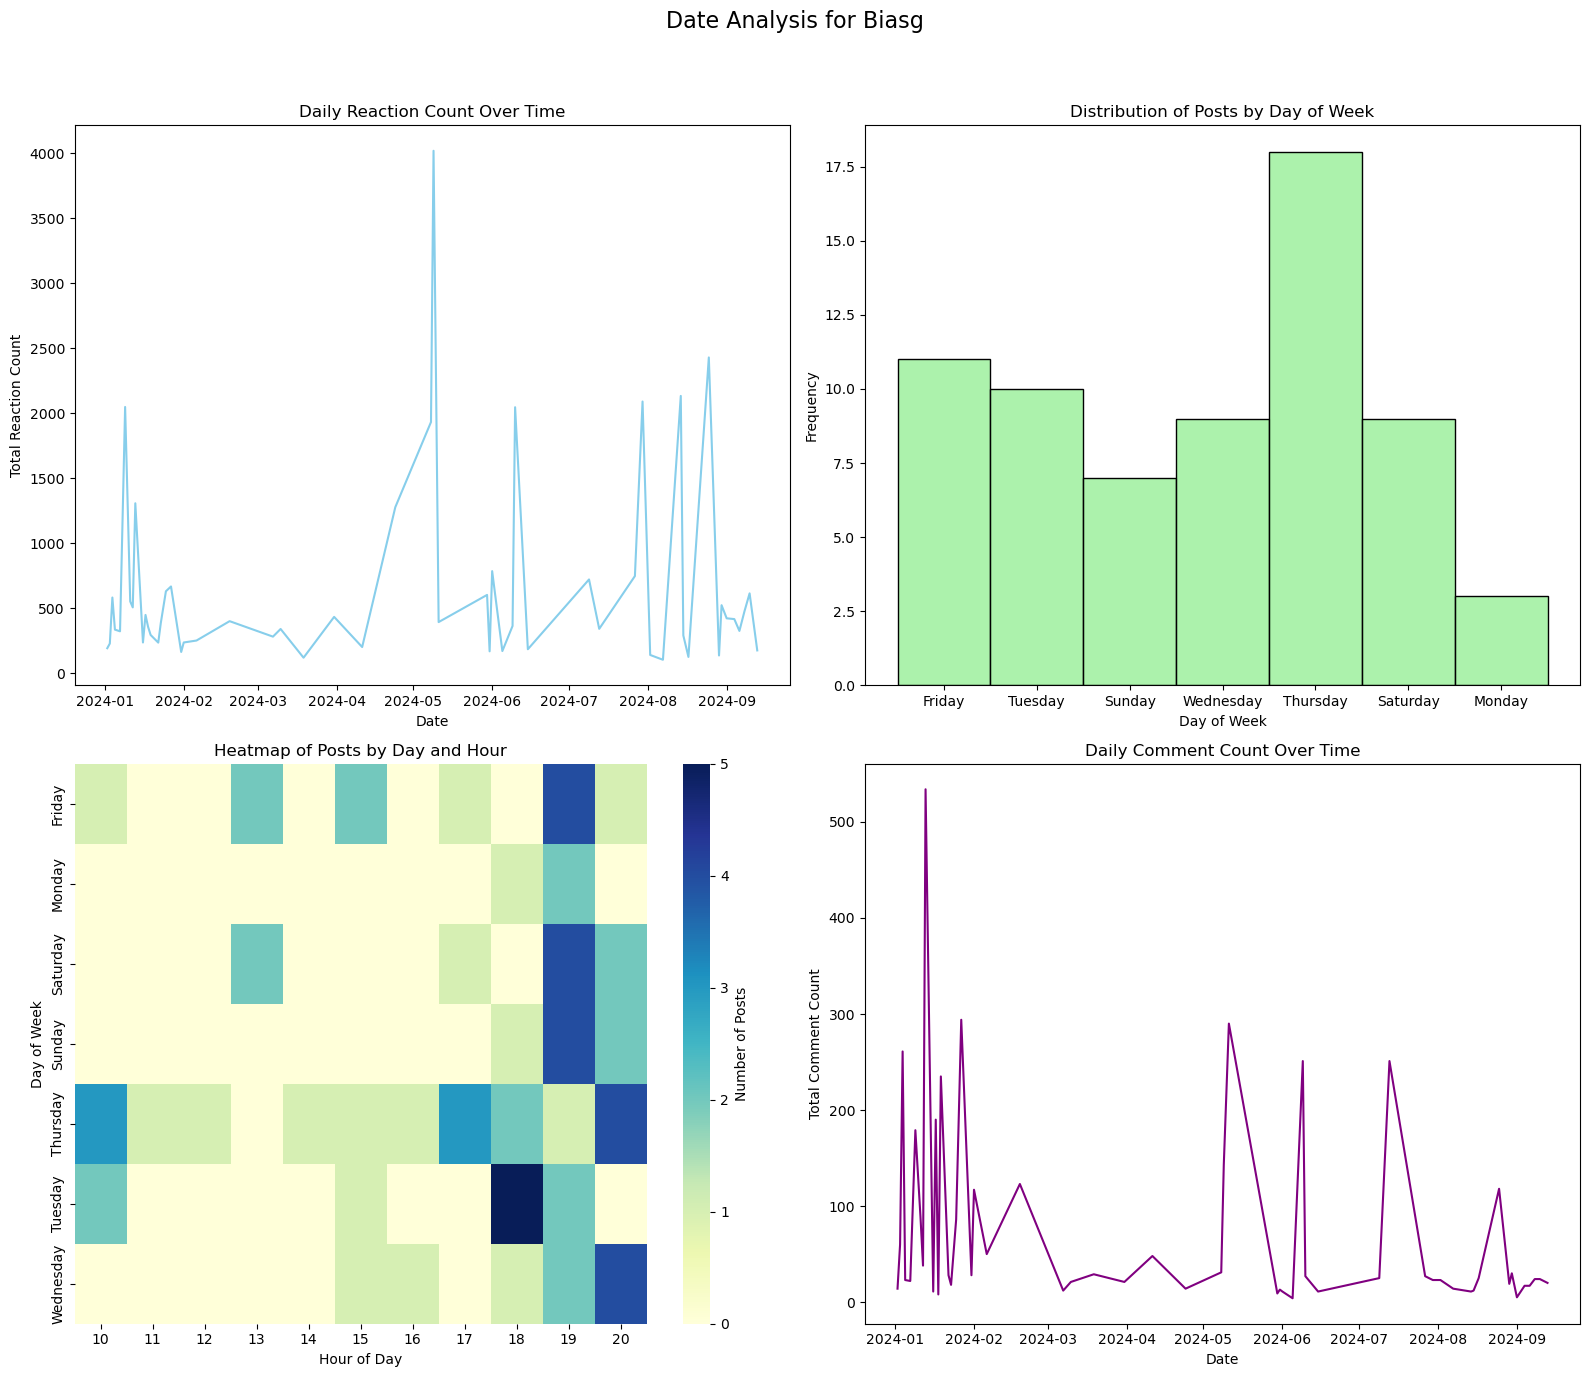

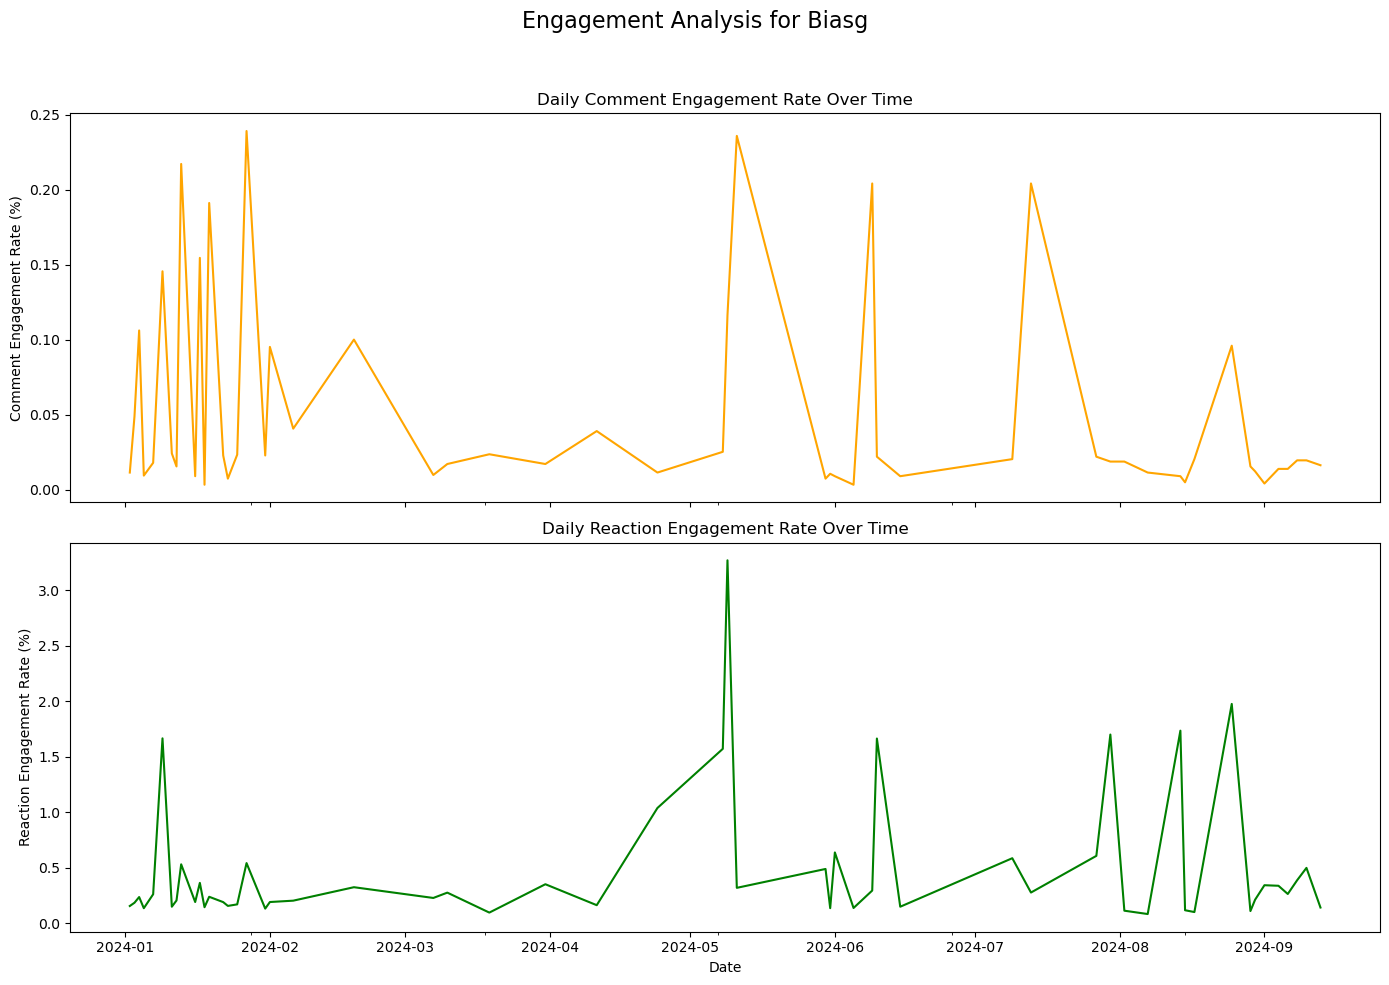

In [886]:
brands = ['heineken', 'beer333', 'biasg']

brand_dfs = {'heineken': heineken, 'beer333': beer333, 'biasg': biasg}

for brand in brands:
    brand_df = brand_dfs[brand]
    
    # Create a figure with subplots for each brand (2x2 grid)
    fig, axes = plt.subplots(2, 2, figsize=(16, 14))
    fig.suptitle(f'Date Analysis for {brand.capitalize()}', fontsize=16)
    
    # Time Series Plot for reaction_count
    daily_reaction_count = brand_df.groupby(brand_df['date'].dt.date)['reaction_count'].sum()
    daily_reaction_count.plot(ax=axes[0, 0], color='skyblue')
    axes[0, 0].set_title('Daily Reaction Count Over Time')
    axes[0, 0].set_xlabel('Date')
    axes[0, 0].set_ylabel('Total Reaction Count')
    
    # Histogram of Posts by Day of Week
    sns.histplot(brand_df['day_name'], discrete=True, color='lightgreen', ax=axes[0, 1])
    axes[0, 1].set_title('Distribution of Posts by Day of Week')
    axes[0, 1].set_xlabel('Day of Week')
    axes[0, 1].set_ylabel('Frequency')
    
    # Heatmap of Posts by Day and Hour
    post_counts = brand_df.groupby(['day_name', 'post_hour']).size().unstack(fill_value=0)
    sns.heatmap(post_counts, cmap='YlGnBu', ax=axes[1, 0], cbar_kws={'label': 'Number of Posts'})
    axes[1, 0].set_title('Heatmap of Posts by Day and Hour')
    axes[1, 0].set_xlabel('Hour of Day')
    axes[1, 0].set_ylabel('Day of Week')
    
    # Time Series Plot for comment_count in the last subplot (axes[1, 1])
    daily_comment_count = brand_df.groupby(brand_df['date'].dt.date)['comment_count'].sum()
    daily_comment_count.plot(ax=axes[1, 1], color='purple')
    axes[1, 1].set_title('Daily Comment Count Over Time')
    axes[1, 1].set_xlabel('Date')
    axes[1, 1].set_ylabel('Total Comment Count')
    
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()
    
    # Create a new figure for the engagement analysis (2 rows, 1 column)
    fig3, axes3 = plt.subplots(2, 1, figsize=(14, 10), sharex=True)
    fig3.suptitle(f'Engagement Analysis for {brand.capitalize()}', fontsize=16)
    
    # Time Series Plot for comment_engagement_rate (first subplot)
    daily_comment_engagement = brand_df.groupby(brand_df['date'].dt.date)['comment_engagement_rate'].mean()
    daily_comment_engagement.plot(ax=axes3[0], color='orange')
    axes3[0].set_title('Daily Comment Engagement Rate Over Time')
    axes3[0].set_xlabel('Date')
    axes3[0].set_ylabel('Comment Engagement Rate (%)')
    
    # Time Series Plot for reaction_engagement_rate (second subplot)
    daily_reaction_engagement = brand_df.groupby(brand_df['date'].dt.date)['reaction_engagement_rate'].mean()
    daily_reaction_engagement.plot(ax=axes3[1], color='green')
    axes3[1].set_title('Daily Reaction Engagement Rate Over Time')
    axes3[1].set_xlabel('Date')
    axes3[1].set_ylabel('Reaction Engagement Rate (%)')
    
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()


**Comment**
**Heineken Key Features**

- **Daily Reaction Count**: There are high fluctuations in reactions, peaking around February and May, with a significant drop in mid-year.
- **Post Distribution**: Most posts occur on Wednesday, followed by Friday and Thursday, with Monday seeing fewer posts.
- **Engagement Patterns**: Engagement rates for both comments and reactions show clear spikes, especially for reactions early in the year and around May. The comment engagement rate peaked in mid-February and May.
- **Timing of Posts**: Posts are more frequent during the late afternoon and early evening, particularly on Fridays, with some activity in the morning.

**333 Beer Key Features**

- **Daily Reaction Count**: Reaction count peaks at the beginning of February and August, with relatively low engagement throughout the year.
- **Post Distribution**: Posting frequency is highest on Fridays and Tuesdays. Monday and Saturday see fewer posts.
- **Engagement Trends**: Both reaction and comment engagement rates show high peaks in early February and August, with reaction rates dropping sharply after those peaks.
- **Posting Times**: More posts occur in the early evening, particularly on Fridays and Sundays, with very few posts in the morning.

**Saigon Beer Key Features**

- **Daily Reaction Count**: Reactions are spread across the year, with a significant spike in May and intermittent activity in other months.
- **Post Distribution**: Thursday is the most active day for posts, followed by Friday and Tuesday. Monday has the least activity.
- **Engagement Trends**: Comment engagement is high at the beginning of the year but decreases over time. Reaction engagement shows spikes in May and intermittent smaller peaks later.
- **Post Timing**: Posting is concentrated in the late afternoon and early evening, especially on Thursdays and Fridays.


In [887]:
brands = ['heineken', 'beer333', 'biasg']

brand_dfs = {'heineken': heineken, 'beer333': beer333, 'biasg': biasg}
for brand_name, df in brand_dfs.items():
    print(f"Day difference for {brand_name.upper()}'s posts:")

    # Calculate the mean day difference
    mean_day_diff = df['days_since_last_post'].mean()
    print(f"Mean day difference: {mean_day_diff:.2f} days")
    print("----------------------------------------")

Day difference for HEINEKEN's posts:
Mean day difference: 8.48 days
----------------------------------------
Day difference for BEER333's posts:
Mean day difference: 7.29 days
----------------------------------------
Day difference for BIASG's posts:
Mean day difference: 2.88 days
----------------------------------------


The mean day difference between posts shows that **HEINEKEN** posts the least frequently with an average of 8.48 days between posts, followed by **BEER333** with 7.29 days. In contrast, **BIASG (Saigon Beer)** has a much higher posting frequency, with a mean day difference of only 2.88 days. This suggests that Saigon Beer is more active in engaging its audience on social media compared to the other two brands.

### 4.3. Descriptive statistics for string features

#### 4.3.1 Full content

##### a. Function to categorize content:

In [888]:
brands = ['heineken', 'beer333', 'biasg']

brand_dfs = {'heineken': heineken, 'beer333': beer333, 'biasg': biasg}
from sklearn.feature_extraction.text import TfidfVectorizer

# Bộ từ dừng tiếng Việt
stop_words = set([
    'cung', 'bạn', 'bị', 'bằng', 'cả', 'của', 'để', 'đã', 'đang', 'được', 'có', 'còn', 'uống', 'không', 'lái', 'xe', 'nhé',
    'hơn', 'hầu', 'hoặc', 'họ', 'i', 'là', 'làm', 'mà', 'mới', 'mỗi', 'như', 'nói', 'chúng', 'cùng', 'một', 'phát', 'dưới', 'tuổi',
    'nó', 'những', 'nơi', 'nên', 'sẽ', 'ta', 'tôi', 'tại', 'từ', 'trong', 'vì', 'với', 'năm', 'các', 'rượu','bia', 'người'
    'và', 'vẫn', 'xem', 'y', 'vừa', 'khi', 'có', 'lại', 'trước', 'sau', 'vậy', 'setting', 'cover', 'avatar', 'event'
])

def preprocess_text(text):
    """
    Tiền xử lý văn bản: chuyển đổi thành chữ thường, loại bỏ dấu câu và số.
    """
    text = text.lower()
    text = re.sub(r'#\w+', '', text)  # Loại bỏ hashtag
    text = re.sub(r'[^\w\s]', '', text)
    text = re.sub(r'\d+', '', text)
    words = text.split()
    filtered_words = [word for word in words if word not in stop_words]
    return ' '.join(filtered_words)

def get_top_features_without_overlap(tfidf_matrix, feature_names, top_n=20):
    """
    Lấy top N cụm từ có điểm TF-IDF cao nhất, nhưng loại bỏ các cụm từ có từ trùng nhau.
    """
    tfidf_scores = np.mean(tfidf_matrix, axis=0).A1  # Chuyển từ ma trận TF-IDF thành mảng
    top_indices = np.argsort(tfidf_scores)[::-1]  # Sắp xếp điểm theo thứ tự giảm dần
    selected_features = []
    used_words = set()

    for i in top_indices:
        feature = feature_names[i]
        words_in_feature = set(feature.split())  # Tách các từ trong cụm từ
        if not words_in_feature.intersection(used_words):  # Kiểm tra xem có từ nào đã sử dụng hay không
            selected_features.append((feature, tfidf_scores[i]))
            used_words.update(words_in_feature)  # Thêm từ vào danh sách đã dùng
        if len(selected_features) >= top_n:
            break

    return selected_features

# Tiền xử lý và tính toán TF-IDF cho từng brand
for brand_name, df in brand_dfs.items():
    print(f"Top features for {brand_name.upper()}:\n")
    
    # Tiền xử lý văn bản
    df['clean_content'] = df['full_content'].apply(preprocess_text)
    
    # Vector hóa văn bản với TF-IDF
    vectorizer = TfidfVectorizer(stop_words='english', ngram_range=(2, 4))  # Tính TF-IDF cho từ và cụm từ 2 đến 3 từ
    tfidf_matrix = vectorizer.fit_transform(df['clean_content'])
    
    # Lấy tên các tính năng
    feature_names = vectorizer.get_feature_names_out()
    
    # Lấy top features không trùng nhau
    top_features = get_top_features_without_overlap(tfidf_matrix, feature_names)
    df.drop(columns = 'clean_content', inplace = True)
    # In kết quả
    for feature, score in top_features:
        print(f"{feature}: {score:.3f}")
    print("\n")


Top features for HEINEKEN:

việt nam: 0.038
heineken vui: 0.016
lễ lo: 0.016
thú vị: 0.015
khám phá: 0.014
phụ nữ: 0.013
triển bền: 0.013
lãnh đạo: 0.013
viên tập: 0.012
quản trị: 0.012
điều mình yêu: 0.012
rất demure rất: 0.012
strongbow sparkling: 0.012
sự nghiệp: 0.011
vào ngày: 0.011
chương trình: 0.011
này sớm: 0.010
ước biết: 0.010
giám đốc: 0.010
nhà máy: 0.010


Top features for BEER333:

đậm chất: 0.028
êm cực êm: 0.027
cơ hội: 0.020
đặc trưng: 0.017
chương trình: 0.016
tinh hoa: 0.016
khuyến mãi: 0.014
khách hàng: 0.014
thẻ cào lần: 0.013
chi tiết: 0.012
chủ nhân: 0.012
anh em: 0.012
emart phan: 0.012
sản phẩm: 0.011
giải vàng: 0.011
công thức: 0.011
chúc mừng: 0.011
nguyên liệu: 0.011
mercedes amg: 0.011
văn trị: 0.010


Top features for BIASG:

anh em: 0.015
tham gia: 0.015
sinh nhật: 0.014
saigon special: 0.013
đóng góp: 0.012
ngày đêm: 0.010
trúng vàng: 0.010
cơ hội: 0.009
săn rồng: 0.009
bội lộc: 0.009
chương trình: 0.008
ăn mừng: 0.008
đặc biệt: 0.008
trách nhiệm: 0.008

Based on the prominent keywords and a manual review of the posts, the author identifies four primary themes in the content shared by the three brands. These themes are as follows:

1. **Brand and Job-Related Posts**: This category encompasses posts related to the brand’s identity, values, and organizational culture, as well as job opportunities, career development, and employee-related content.

2. **Promotional and Event Posts**: Posts under this theme focus on marketing campaigns, promotions, contests, giveaways, and event announcements that aim to engage customers and promote product offerings.

3. **CSR-Related Posts**: This theme includes content addressing the brands’ Corporate Social Responsibility (CSR) initiatives, such as sustainability efforts, community engagement, and social impact projects.

4. **Appearance and Setting Posts**

In [889]:
brands = ['heineken', 'beer333', 'biasg']

brand_dfs = {'heineken': heineken, 'beer333': beer333, 'biasg': biasg}
# Define keywords for each category
brand_and_job_keywords = ['nhân viên', 'sự nghiệp', 'thực tập', 'tập sự', 'lãnh đạo', 'vị trí', 'heineken việt nam', 'nghề nghiệp', 'ken', 'làm việc', 'chất', 'bia sài gòn', 'special', 'larue', 'export premium', 'bia 333', '333', 'pilsner', 'strongbow', 'tiger', 'bia saigon', 'bia sg']
promotional_and_event_keywords = ['khuyến mãi', 'khuyến mại', 'cơ hội', 'sự kiện', 'tiệc', 'quà', 'giải', 'thưởng', 'prize', 'tham gia', 'kết quả', 'livestream', 'sự kiện', 'thú vị', 'lễ', 'sản phẩm']
CSR_keywords = ['bền vững', 'phụ nữ', 'chung tay', 'đồng hành', 'văn hoá', 'lan toả', 'tôn vinh',  'bảo vệ', 'cảm hứng', 'bảo tồn', 'sẻ chia', 'câu chuyện']
appearance_setting_keywords = ['avatar', 'cover', 'event', 'setting']

# Function to remove hashtags from content
def remove_hashtags(content):
    return re.sub(r'#\w+', '', content).strip()

# Function to assign binary features based on keywords
def assign_post_category_features(df):
    # Ensure all keywords are strings
    brand_and_job_keywords_str = [str(keyword).lower() for keyword in brand_and_job_keywords]
    promotional_and_event_keywords_str = [str(keyword).lower() for keyword in promotional_and_event_keywords]
    CSR_keywords_str = [str(keyword).lower() for keyword in CSR_keywords]
    appearance_setting_keywords_str = [str(keyword).lower() for keyword in appearance_setting_keywords]
    
    # Apply feature assignment after removing hashtags
    df['cleaned_content'] = df['full_content'].apply(remove_hashtags)
    df['brand_and_job_related_posts'] = df['cleaned_content'].apply(lambda x: any(keyword in str(x).lower() for keyword in brand_and_job_keywords_str)).astype(int)
    df['promotional_and_event_posts'] = df['cleaned_content'].apply(lambda x: any(keyword in str(x).lower() for keyword in promotional_and_event_keywords_str)).astype(int)
    df['CSR_related_posts'] = df['cleaned_content'].apply(lambda x: any(keyword in str(x).lower() for keyword in CSR_keywords_str)).astype(int)
    df['appearance_setting_posts'] = df['cleaned_content'].apply(lambda x: any(keyword in str(x).lower() for keyword in appearance_setting_keywords_str)).astype(int)
    
    # Drop the temporary 'cleaned_content' column
    df.drop(columns=['cleaned_content'], inplace = True)
    
    return df
for brand, df in brand_dfs.items():
    brand_dfs[brand] = assign_post_category_features(df)

The group of authors define several keyword lists for different categories, including **'brand_and_job_keywords'** (related to job opportunities and branding), **'promotional_and_event_keywords'** (for promotions and events), **'CSR_keywords'** (Corporate Social Responsibility refers to a company's efforts to contribute positively to society and the environment, beyond just making profits. Analyzing CSR is important because it reflects how brands present their values and social commitments to the public, which can influence customer perception and loyalty. By including CSR in the group's analysis, the team can assess how much emphasis each brand places on these initiatives, providing insights into their broader reputation and brand identity strategies), and **'appearance_setting_keywords'** (for visual branding elements like avatars and covers). 

The **'remove_hashtags'** function removes hashtags from a given content string using a regular expression because the content of the post includes hashtags that are mostly about brand names (which are the keywords to identify brand-related posts). The 'assign_post_category_features' function processes the input DataFrame by converting all keywords to lowercase, removing hashtags from the content in the 'full_content' column, and creating binary columns to indicate whether the content includes any of the keywords from the respective categories. The temporary 'cleaned_content' column used for this processing is then dropped.

Finally, a 'for' loop iterates through each brand's DataFrame and applies the 'assign_post_category_features' function, updating the 'brand_dfs' dictionary with the processed DataFrames. 

The result is that the posts’ content are categorized into 4 types:

1. **Brand and job-related posts** refer to content that highlights a company's identity, values, and organizational culture. These posts often include job opportunities, career development insights, and employee-focused updates, aiming to build a connection between the brand and its workforce or potential recruits.

2. **Promotional and event posts** center on marketing initiatives, such as campaigns, promotions, contests, giveaways, and event announcements. These posts aim to engage customers and boost visibility for the brand's products or services.

3. **CSR-related posts** focus on Corporate Social Responsibility efforts, showcasing a brand's commitment to sustainability, community engagement, and social impact. These posts reflect the company's dedication to positive contributions beyond profit.

4. **Appearance and setting posts** involve updates to the company's avatar or page cover.


##### b. Results:

Total number of posts for heineken in 2024 up to now: 25


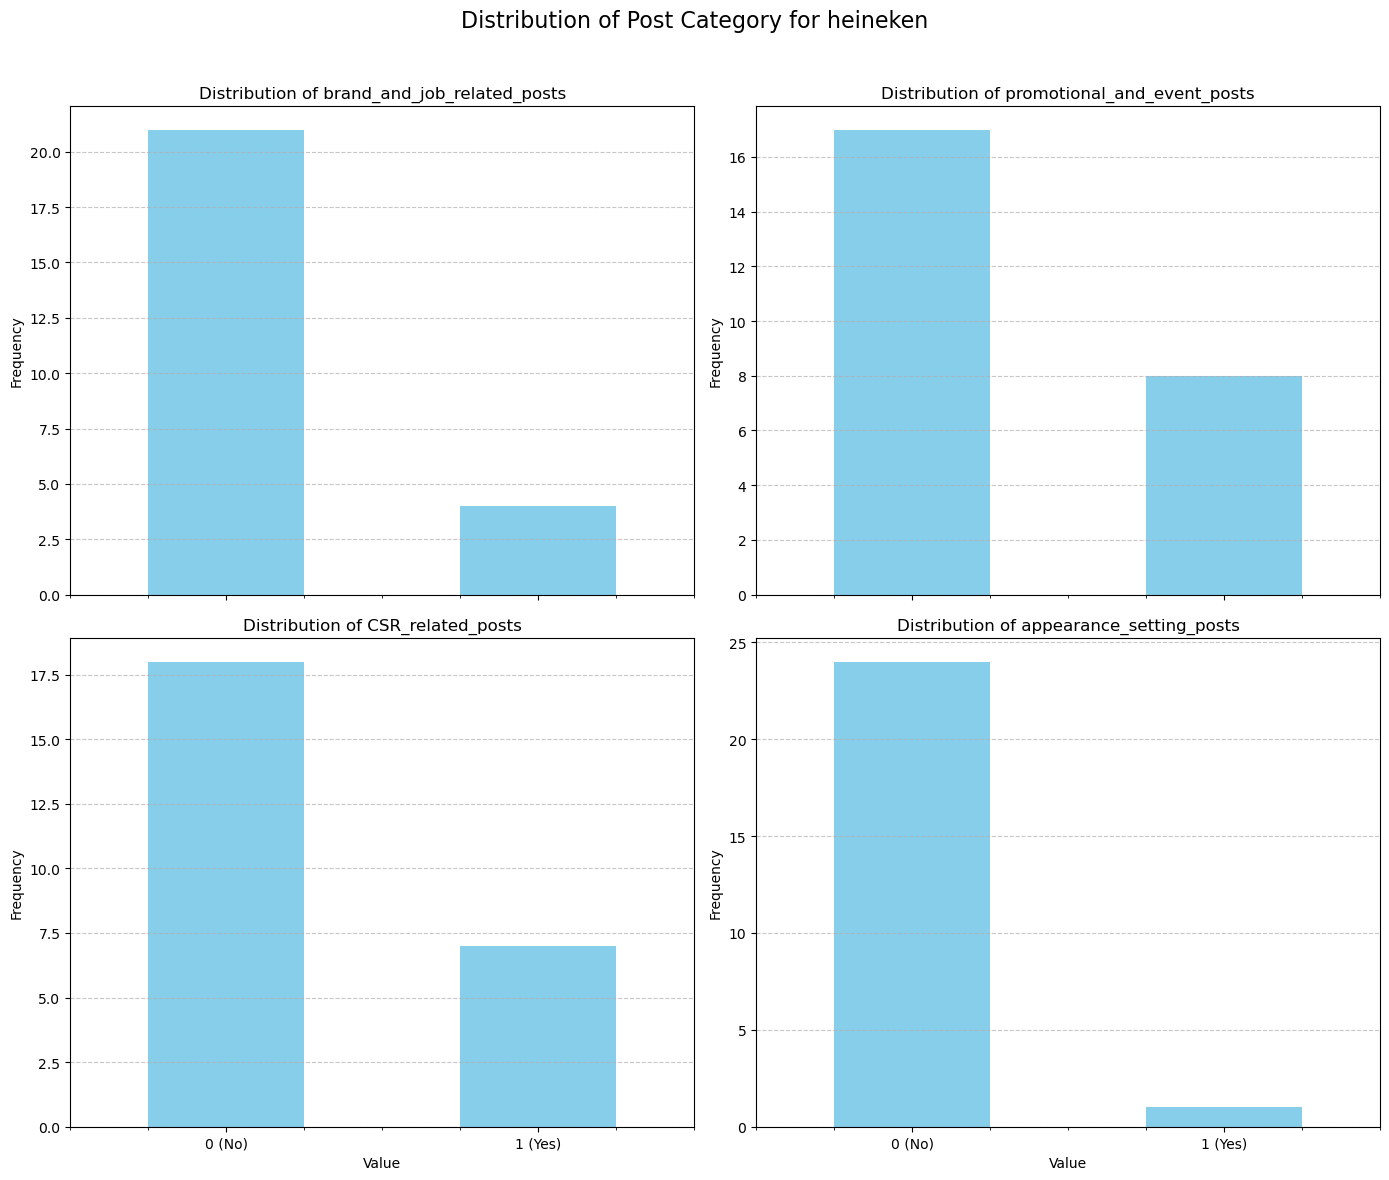

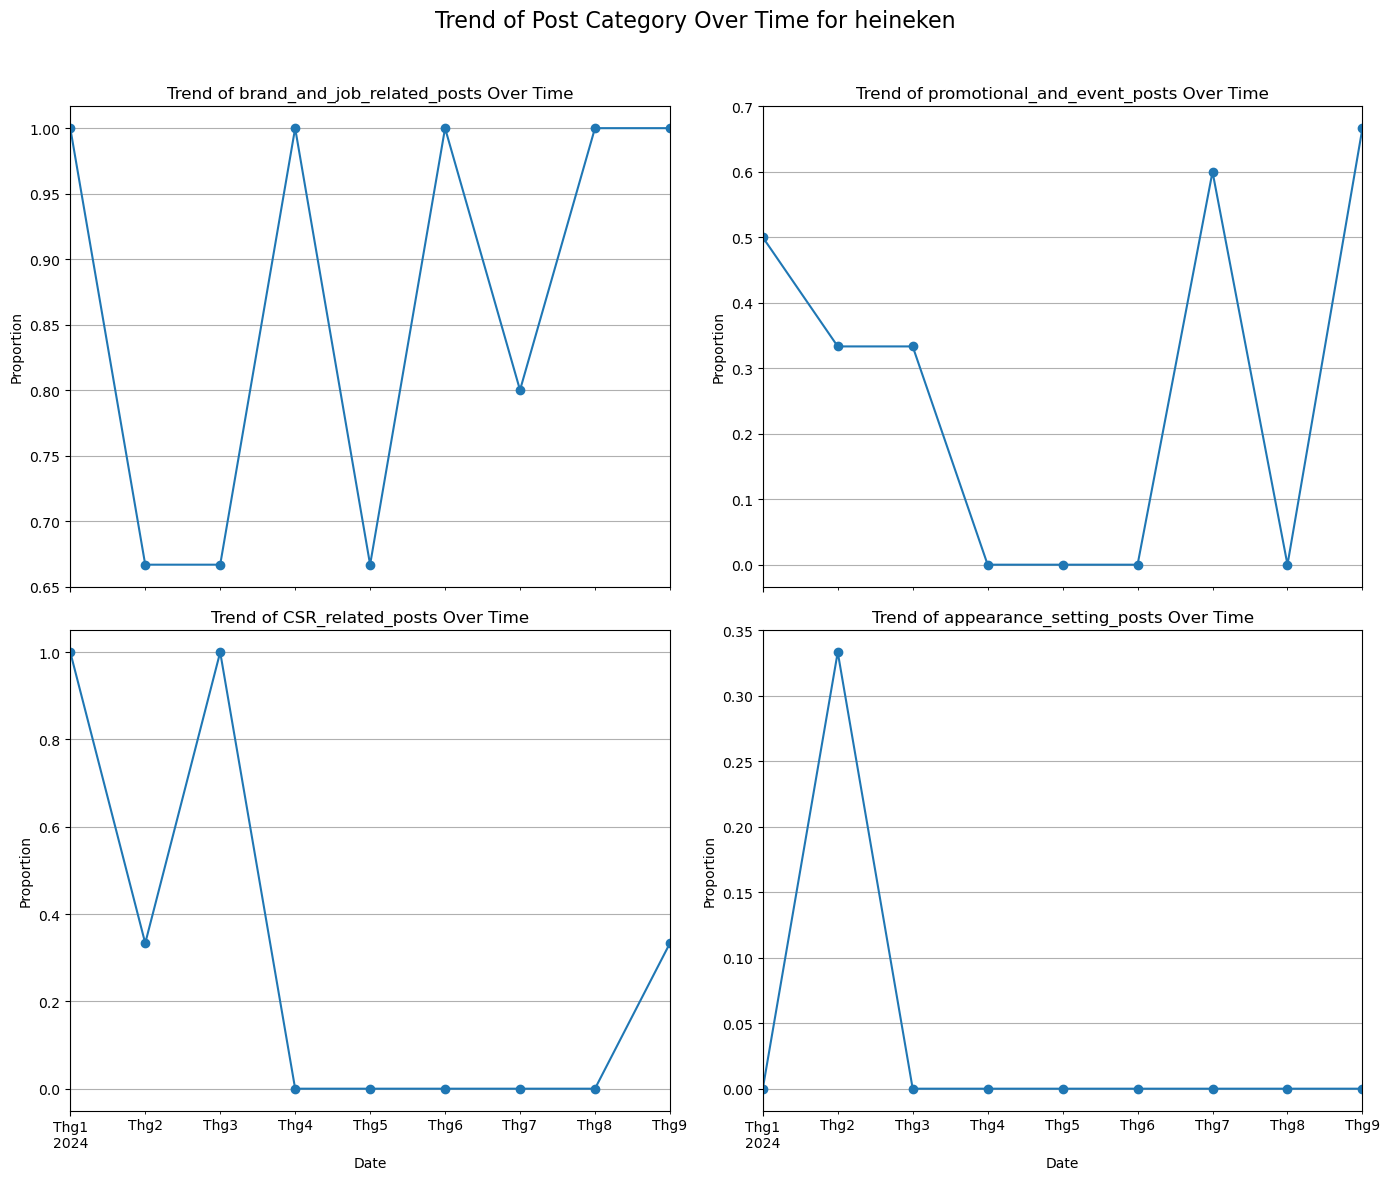

Total number of posts for beer333 in 2024 up to now: 28


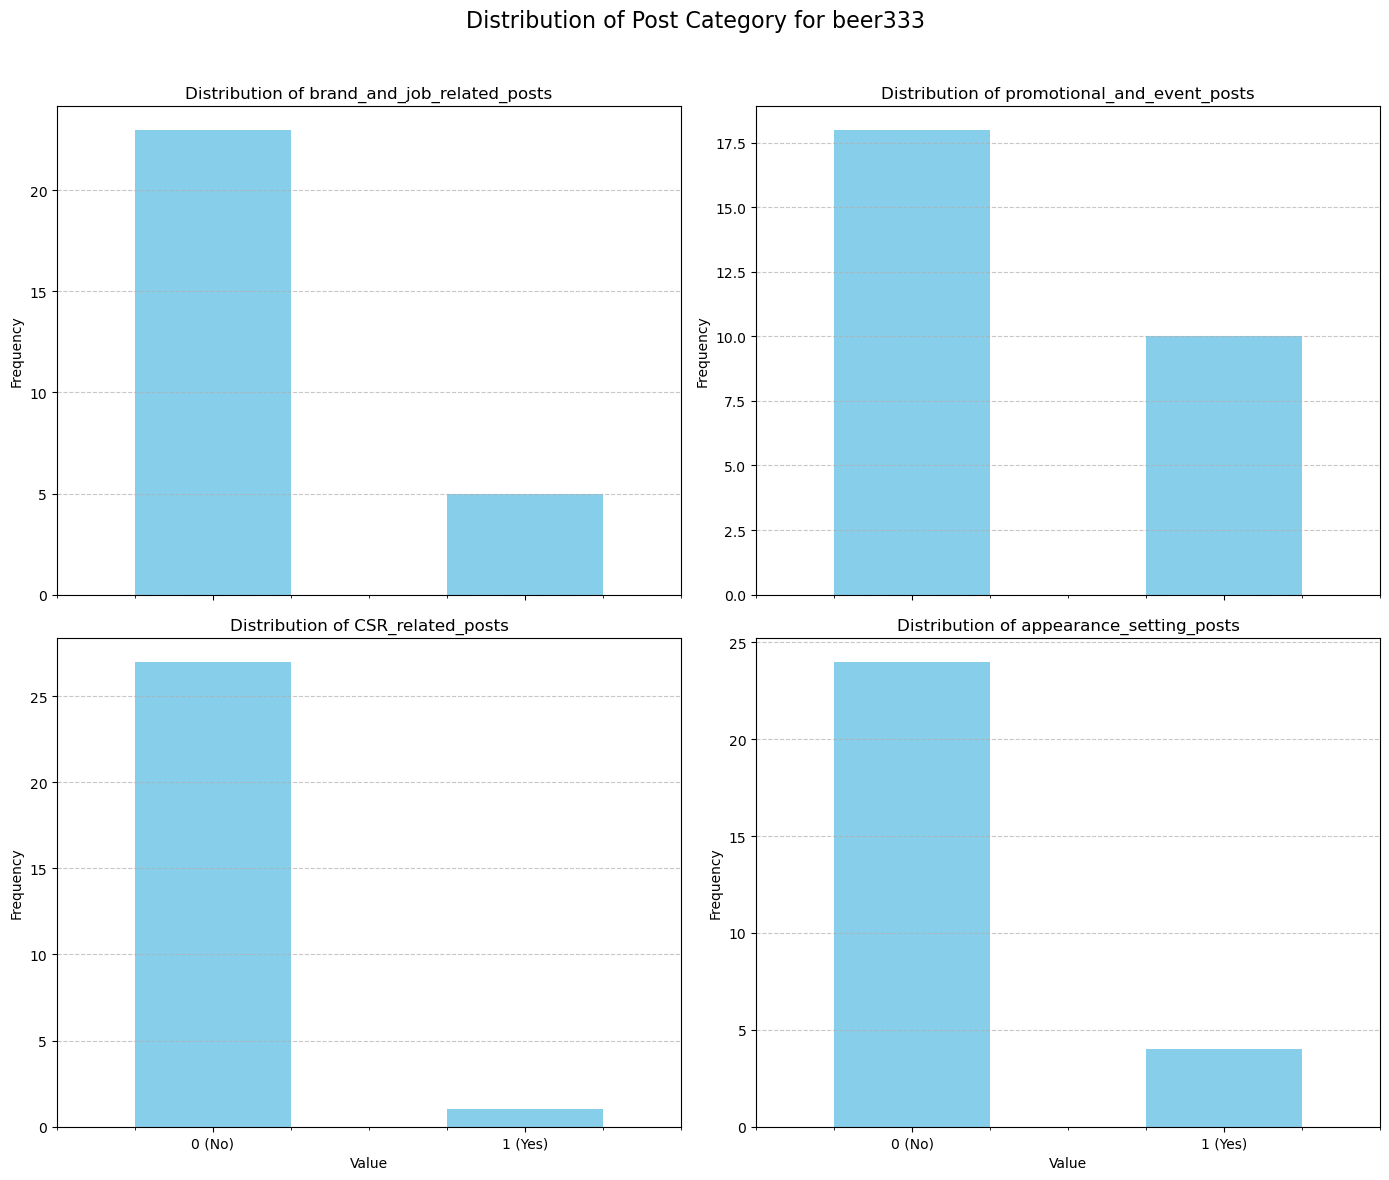

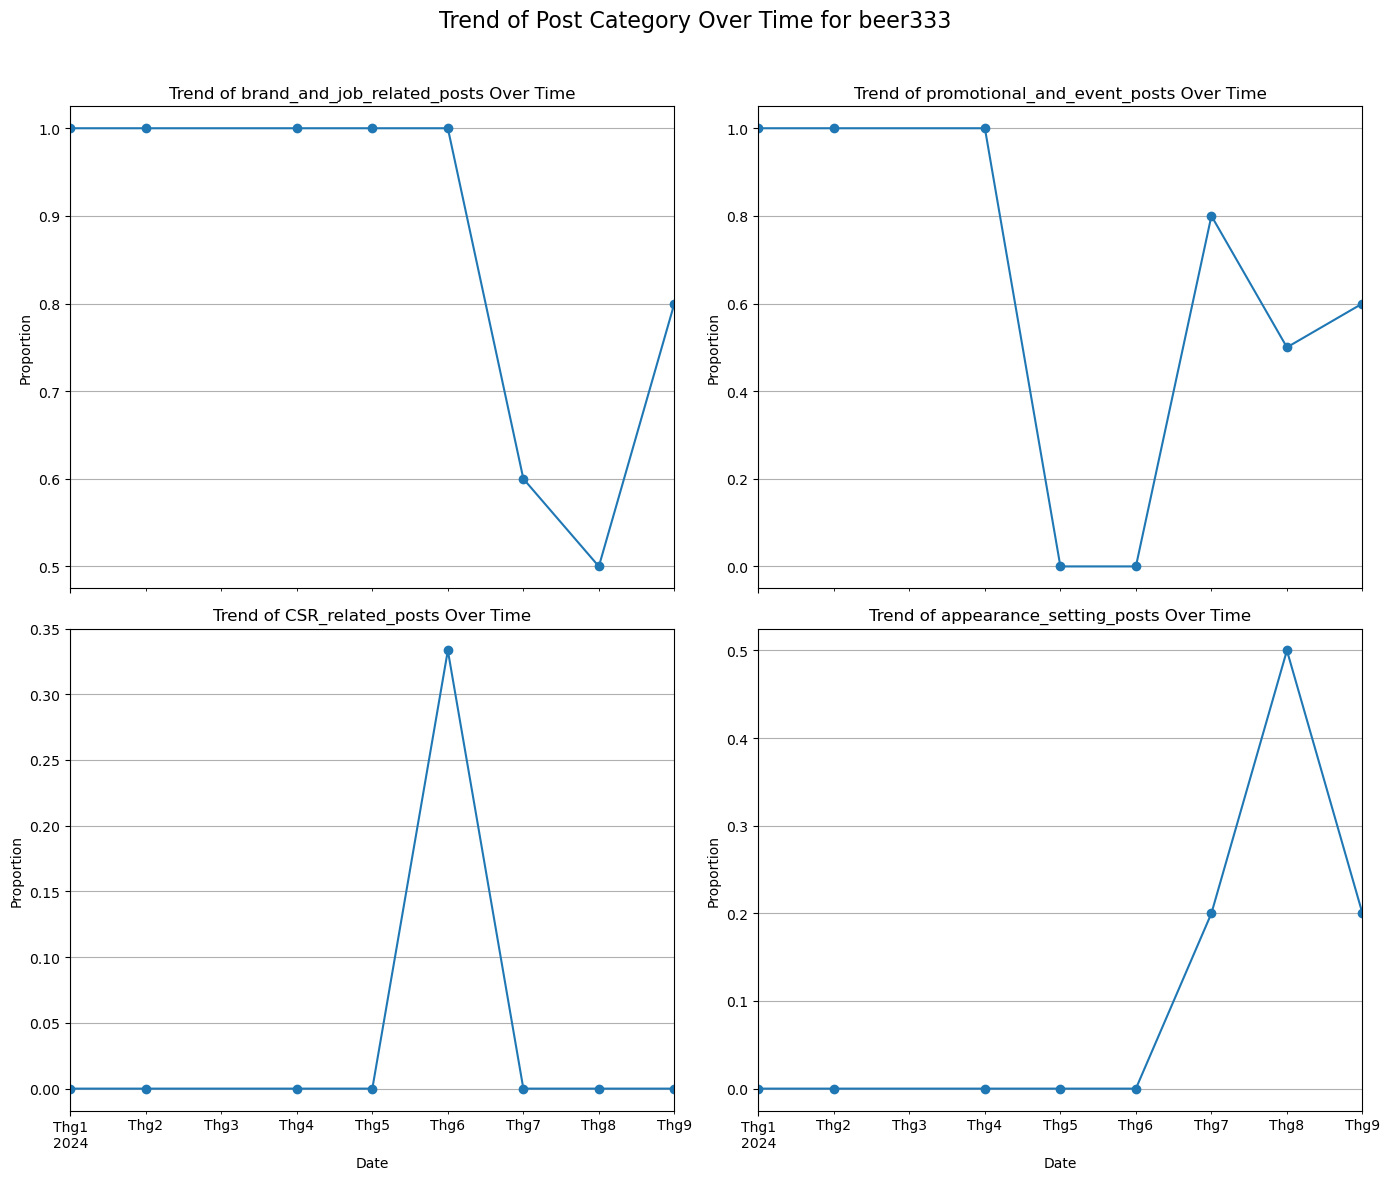

Total number of posts for biasg in 2024 up to now: 67


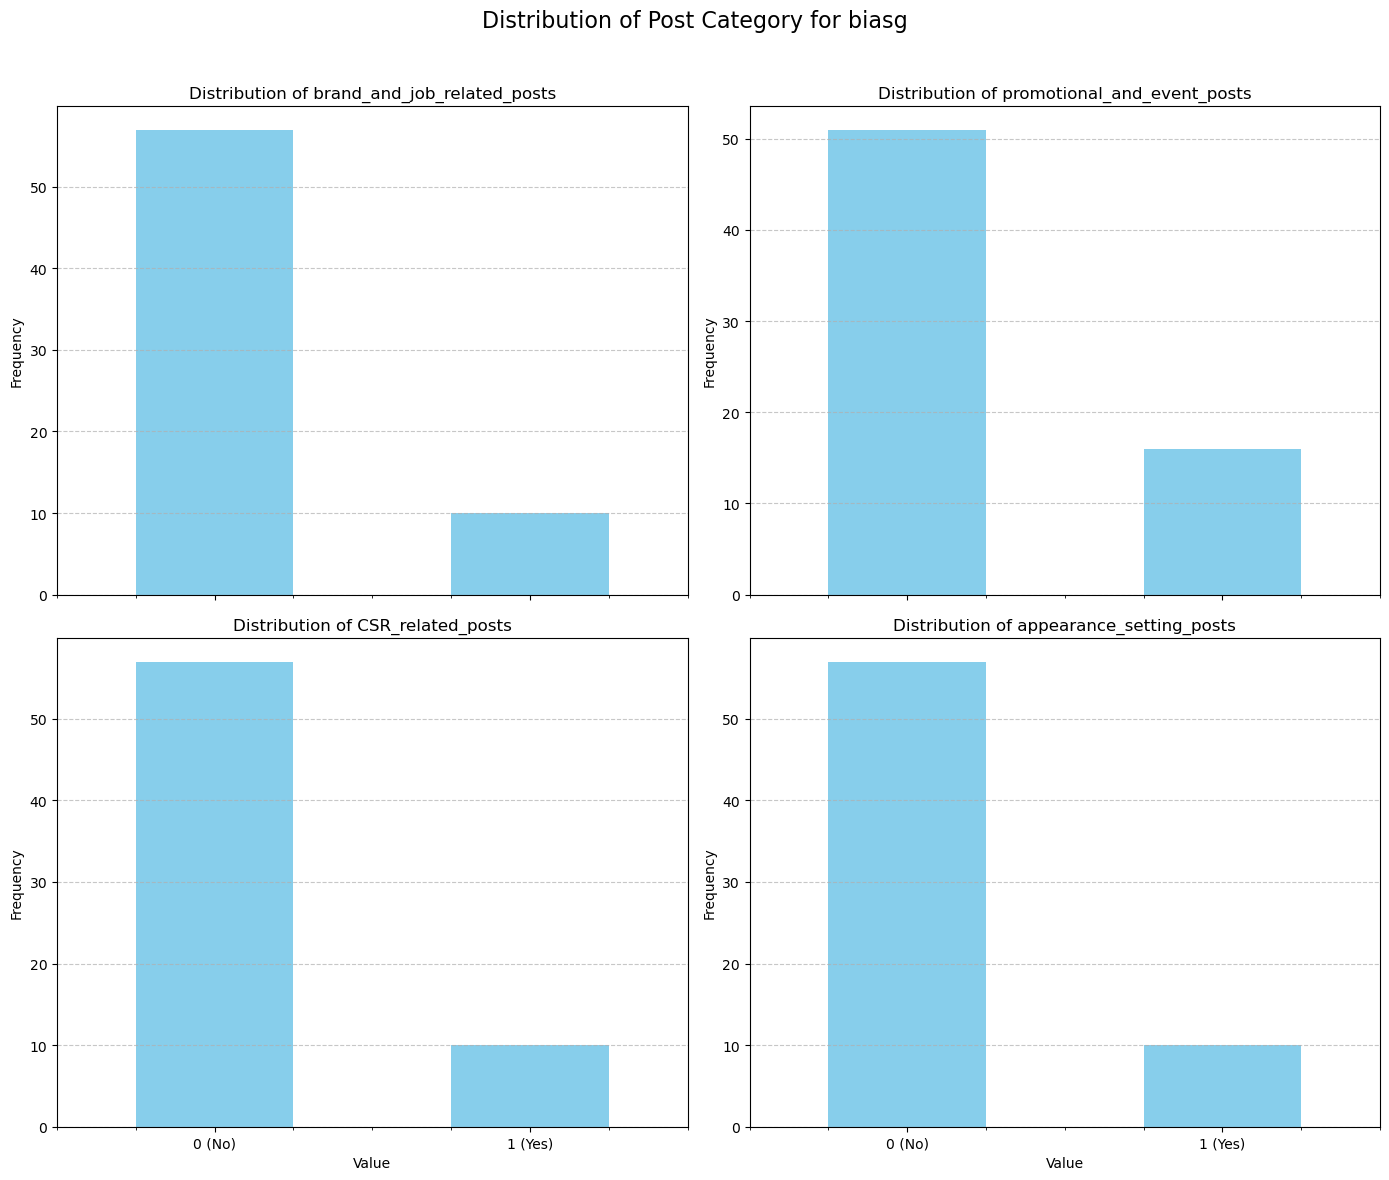

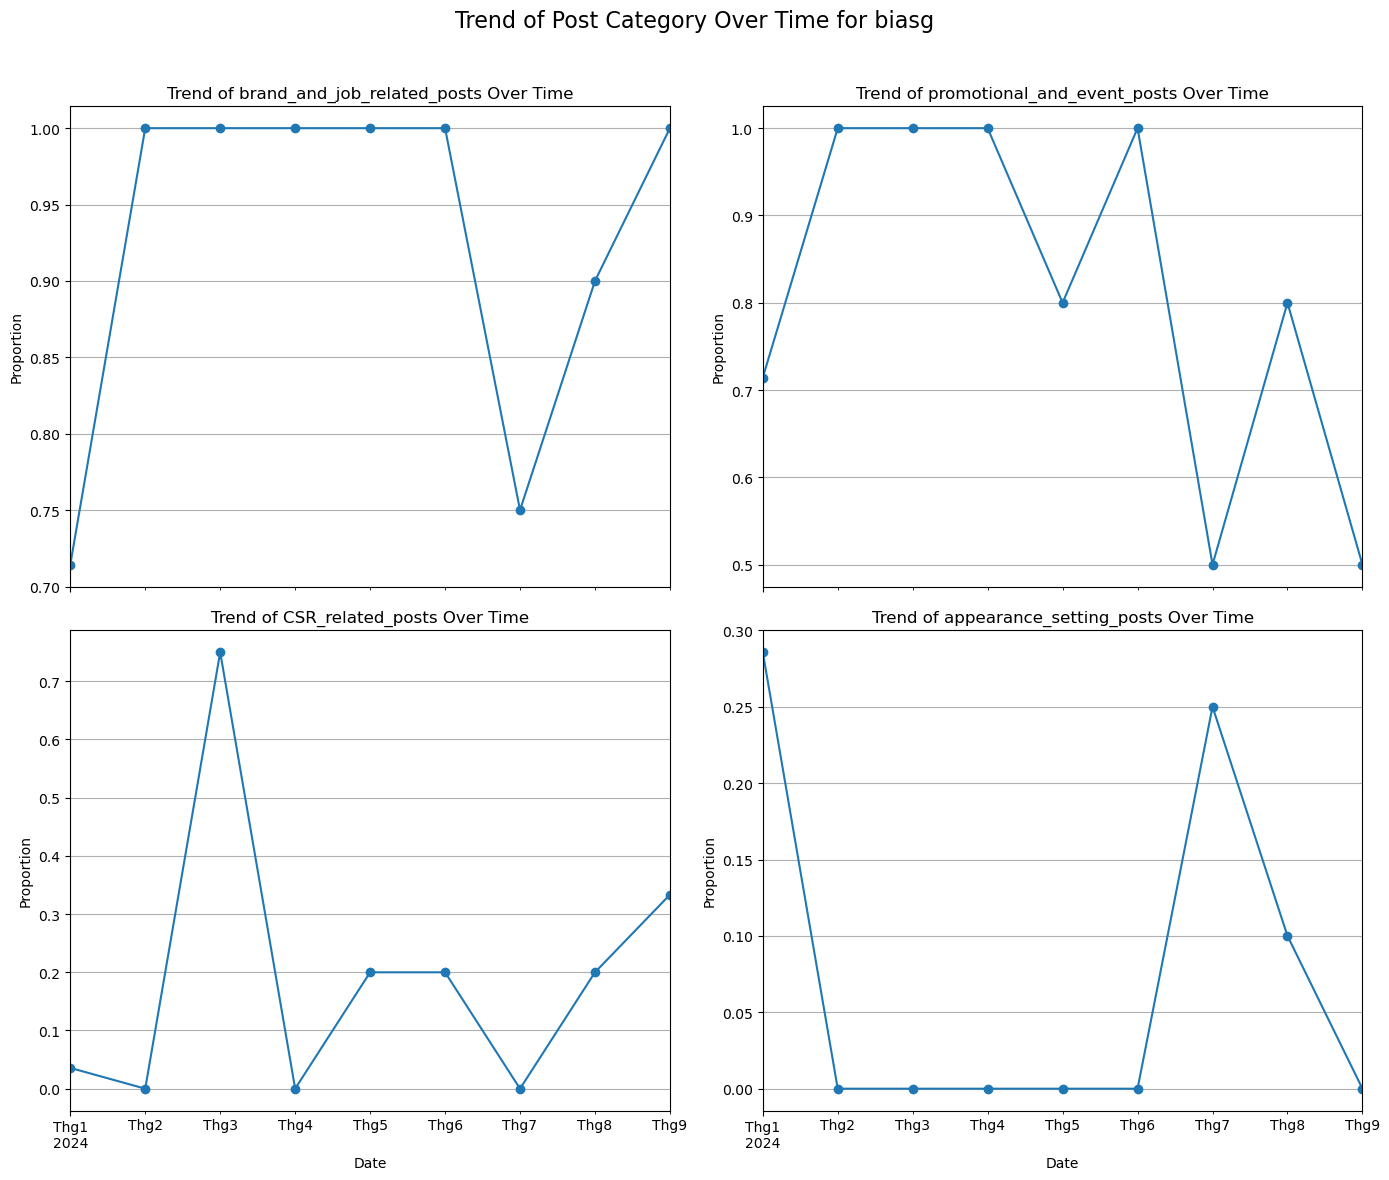

In [890]:
# Define the Post Category
binary_features = ['brand_and_job_related_posts', 'promotional_and_event_posts', 'CSR_related_posts', 'appearance_setting_posts']
# Function to filter data and generate initial plots
def generate_initial_plots(df, brand_name):
    

    # Calculate total number of posts for the brand in 2024
    total_posts = len(df)
    print(f'Total number of posts for {brand_name} in 2024 up to now: {total_posts}')
    # 1. Distribution of Post Category
    fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(14, 12), sharex=True)
    fig.suptitle(f'Distribution of Post Category for {brand_name}', fontsize=16)
    
    for i, feature in enumerate(binary_features):
        ax = axes[i // 2, i % 2]
        df[feature].value_counts().plot(kind='bar', color='skyblue', ax=ax)
        ax.set_title(f'Distribution of {feature}')
        ax.set_xlabel('Value')
        ax.set_ylabel('Frequency')
        ax.set_xticks([0, 1])
        ax.set_xticklabels(['0 (No)', '1 (Yes)'], rotation=0)
        ax.grid(axis='y', linestyle='--', alpha=0.7)
    
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()

    # 2. Time Series Analysis
    fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(14, 12), sharex=True)
    fig.suptitle(f'Trend of Post Category Over Time for {brand_name}', fontsize=16)
    
    for i, feature in enumerate(binary_features):
        ax = axes[i // 2, i % 2]
        df.groupby(df['date'].dt.to_period('M'))[feature].mean().plot(kind='line', marker='o', ax=ax)
        ax.set_title(f'Trend of {feature} Over Time')
        ax.set_xlabel('Date')
        ax.set_ylabel('Proportion')
        ax.grid(True)
    
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()

brand_dfs = {'heineken': heineken, 'beer333': beer333, 'biasg': biasg}
# Generate initial plots for each brand
for brand, df in brand_dfs.items():
    generate_initial_plots(df, brand)

**Heineken:**

The analysis of Heineken's post category distribution reveals a strong emphasis on brand identity and promotional activities as welll as Heineken is the brand that has the highest number of CSR-related posts, highlighted the brand strong commitment to the community.

The analysis of Heineken's post categories overtime reveals a cyclical pattern in posting activity throughout the year. Brand and job-related, promotional and event, CSR-related, and appearance and setting posts all exhibit distinct seasonal trends, with peaks and troughs occurring at various times. While some categories maintain a relatively consistent pattern, others experience significant fluctuations, indicating a dynamic content strategy. These trends suggest a strategic approach to content creation, focusing on specific themes at different times of the year to align with marketing objectives, engage the target audience, and support brand identity. Further analysis considering external events, product launches, marketing campaigns, and engagement metrics could provide deeper insights into Heineken's social media strategy and the effectiveness of their content in achieving desired outcomes.


**333 Beer:**

The analysis of 333 Beer's post categories distribution reveals a strong emphasis on brand building content, suggesting that the brand prioritizes reinforcing its identity and engaging with its audience. While the brand actively engages in marketing campaigns and events, these promotional activities are not as prominent as the focus on brand and job-related content.

The trends of four post categories for 333 Beer over time is indicated as follows: Brand and job-related posts experienced a significant spike early in the year, likely indicating a focus on establishing brand identity and attracting talent. However, this category subsequently declined steadily, potentially due to changes in marketing strategies or a decrease in employee branding needs. Promotional and event posts began with a high proportion, suggesting a strong promotional push, but experienced a dramatic drop around March, possibly influenced by factors such as budget constraints or altered marketing strategies. The proportion of CSR-related posts remained relatively low throughout the year, suggesting a less prominent role for CSR in Beer333's overall strategy. However, a noticeable spike in June indicates a deliberate effort to highlight CSR initiatives during that period, this is because this the period that have Father Day, the brand may post family content to boost engagement. In contrast, appearance and setting posts exhibited a steady increase throughout the year, suggesting a growing emphasis on creating a specific brand aesthetic.

**Saigon Beer:**

SAigon Beer is the brand with highest posting frequency among the 3 brands, up to now the brand has posted 67 posts, nearly tripple the two other brands. The analysis of the post category distribution of Saigon Beer reveals a strong emphasis on promotional activities and events, the brand focusing on promoting special cuisines of different provinces in Vietnam in the forms of minigames, or create special offers based on the birthday month of specific zodiac signs, these are effective strategy to boost user engagement and brand identity.

The trends of four post categories of Saigon Beer over time is as follows. Brand and job-related posts have maintained a relatively steady presence, suggesting a consistent focus on brand identity and employer branding content, this is due to the introduction of Export Premium, a new product of the brand at the beginning of 2024. Promotional and event posts have exhibited a notable upward trend, this is because earlier this year the brand create a series of 7-week livestream events with many promotional posts for the series indicating heightened marketing efforts or seasonal promotions. CSR-related posts have experienced a gradual increase, reflecting a growing emphasis on corporate social responsibility and sustainability. 




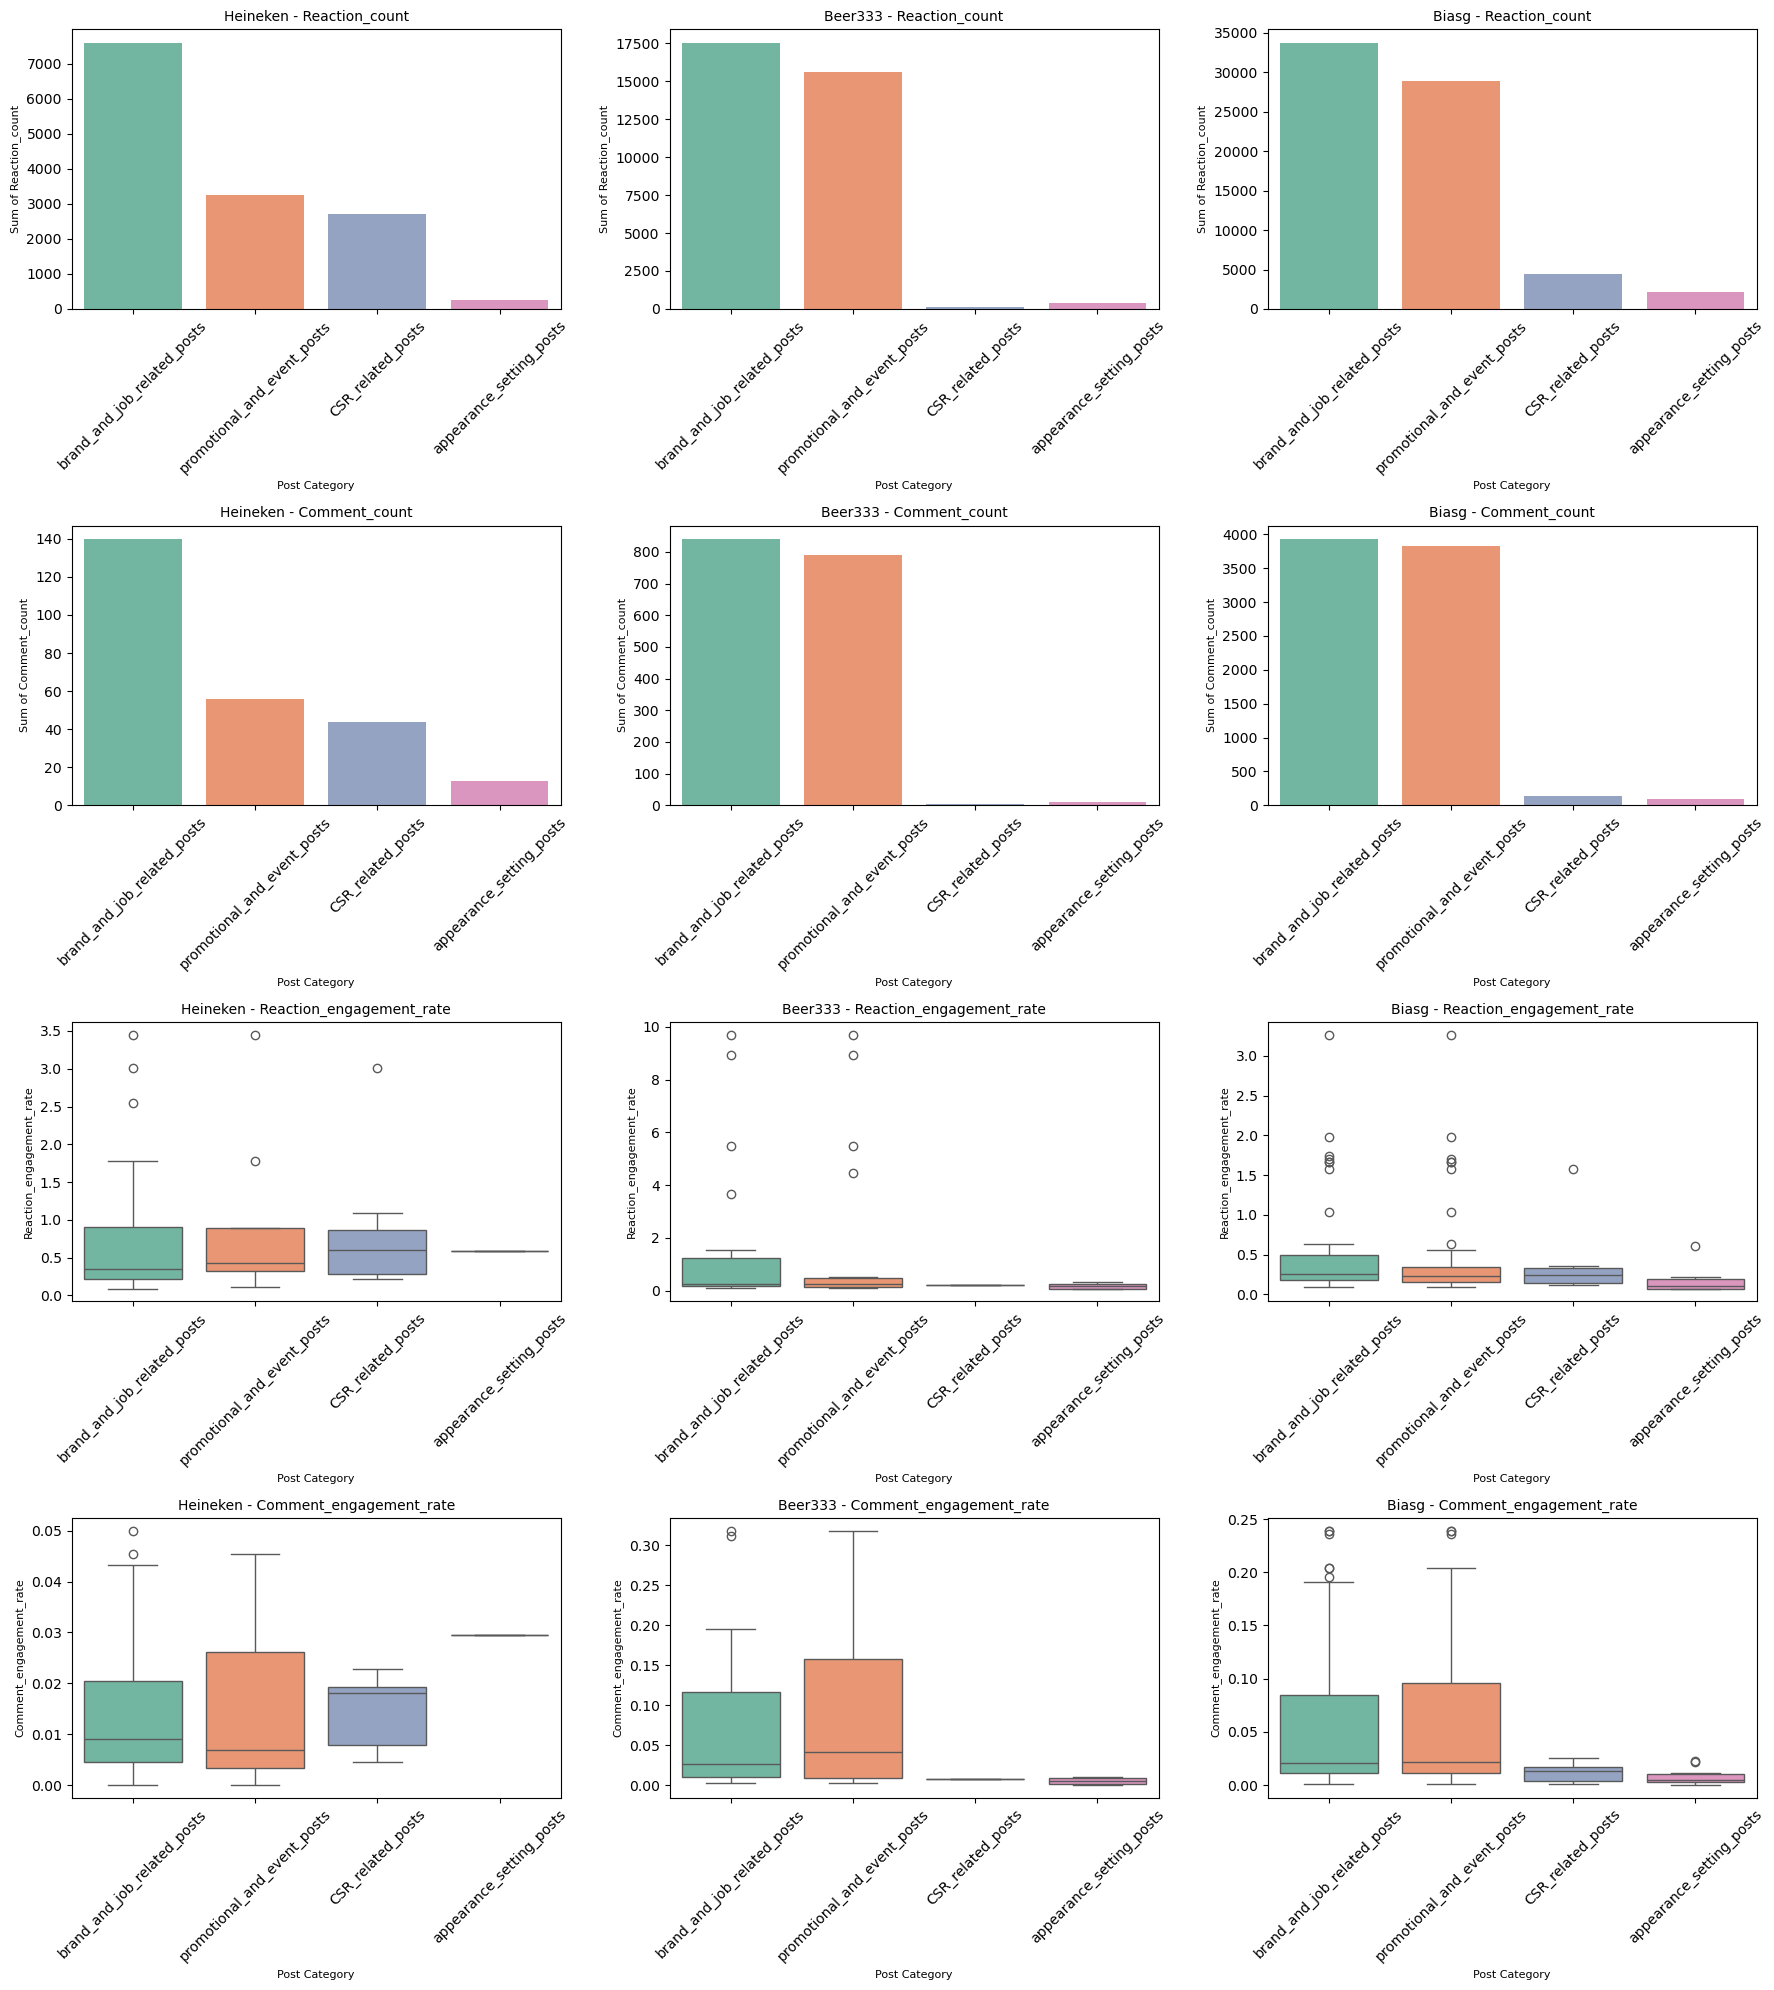

In [891]:
brands = ['heineken', 'beer333', 'biasg']

brand_dfs = {'heineken': heineken, 'beer333': beer333, 'biasg': biasg}
# Define binary features and metrics
post_category = ['brand_and_job_related_posts', 'promotional_and_event_posts', 'CSR_related_posts', 'appearance_setting_posts']
metrics = ['reaction_count', 'comment_count', 'reaction_engagement_rate', 'comment_engagement_rate']

# Colors for each binary feature
colors = sns.color_palette("Set2", len(post_category))

# Set up a 4x3 grid (4 metrics and 3 brands)
fig, axes = plt.subplots(4, 3, figsize=(18, 20))
plt.subplots_adjust(hspace=0.5, wspace=0.4)

# Loop through each metric and brand, and create subplots
for i, metric in enumerate(metrics):
    for j, brand in enumerate(brands):
        df = brand_dfs[brand]

        if metric in ['reaction_count', 'comment_count']:
            # Calculate the sum of metrics for each binary feature
            binary_sums = {feature: df[df[feature] == 1][metric].sum() for feature in post_category}
            
            # Create DataFrame for plotting
            plot_df = pd.DataFrame(binary_sums, index=[metric]).T  # Transpose for easier plotting
            plot_df.index.name = 'Post Category'

            ax = axes[i, j]  # Get the correct subplot (row = metric, col = brand)
            sns.barplot(x=plot_df.index, y=plot_df[metric], palette=colors, ax=ax)
            ax.set_title(f'{brand.capitalize()} - {metric.capitalize()}', fontsize=10)
            ax.set_ylabel(f'Sum of {metric.capitalize()}', fontsize=8)
            ax.set_xlabel('Post Category', fontsize=8)
            ax.tick_params(axis='x', rotation=45)
        
        else:
            # For engagement rates, filter to include only 'Yes' posts
            filtered_df = df[df[post_category].any(axis=1)]

            # Reshape the DataFrame to make 'Post Category' a column
            melted_df = filtered_df.melt(id_vars=[metric], value_vars=post_category, var_name='Post Category', value_name='Included')
            melted_df = melted_df[melted_df['Included'] == 1]
            
            # Create a box plot comparing the four types of post categories
            ax = axes[i, j]  # Get the correct subplot (row = metric, col = brand)
            sns.boxplot(x='Post Category', y=metric, data=melted_df, palette=colors, ax=ax)
            ax.set_title(f'{brand.capitalize()} - {metric.capitalize()}', fontsize=10)
            ax.set_ylabel(f'{metric.capitalize()}', fontsize=8)
            ax.set_xlabel('Post Category', fontsize=8)
            ax.tick_params(axis='x', rotation=45)

# Remove the last row's empty plots (if there were any)
for i in range(len(brands), 3):
    for j in range(4):
        fig.delaxes(axes[j, i])

plt.tight_layout()
plt.show()

**Comment**

1. **Brand and Job-Related Posts**
- **High reaction and comment count, but moderate to low engagement rates**:  
  For all three companies, brand and job-related posts consistently attract the highest volume of reactions and comments. However, the engagement rates tend to be moderate at best, with Heineken and Beer 333 showing higher engagement outliers, while Bia Saigon shows very low median engagement rates.
- **Trend**: High visibility and reach do not necessarily translate to meaningful engagement. These posts draw attention but lack depth in interactions.

2. **Promotional and Event-Related Posts**
- **Moderate to high reaction and comment count with mixed engagement**:  
  Promotional and event-related posts tend to perform similarly across the three brands, attracting high comment and reaction counts. However, the engagement rate is mixed, with Heineken showing wider variability (due to outliers) and Beer 333 and Bia Saigon indicating lower median engagement rates.
- **Trend**: Promotional content can draw attention, but engagement is inconsistent, suggesting that specific promotions or events resonate more than others.

3. **CSR-Related Posts**
- **Lower reaction and comment count but higher engagement rates**:  
  Across all three companies, CSR-related posts consistently receive fewer reactions and comments, but they show higher engagement rates compared to brand and promotional posts. For example, Beer 333 has higher engagement outliers in this category.
- **Trend**: CSR-related posts, while less popular in volume, tend to drive deeper and more meaningful interactions with the audience.

4. **Appearance-Setting Posts**
- **Lowest reaction and comment count with limited engagement**:  
  These posts consistently perform poorly across all three brands, receiving the fewest reactions and comments. Their engagement rates also remain low, suggesting minimal interaction or resonance with the audience.
- **Trend**: Appearance-setting posts are generally ineffective at driving both attention and engagement, indicating they are less appealing to social media audiences.

**Key Insights**
- **High Reaction/Comment Volume ≠ High Engagement**:  
  All three brands show that while some post categories (brand/job-related, promotional) attract a high volume of reactions and comments, they often lack strong engagement, indicating shallow interactions.
- **CSR Content Fosters Deeper Engagement**:  
  Even though CSR-related posts have fewer reactions and comments, they often have higher engagement rates, highlighting the power of social responsibility content in driving meaningful interaction.
- **Content Type Matters**:  
  The type of content plays a crucial role in both visibility and engagement. Promotional, brand, and CSR-related content engage users differently, with CSR posts standing out for their ability to generate deeper interactions despite lower overall numbers.

**In conclusion**, for Heineken, Beer 333, and Bia Saigon, content that resonates deeply (such as CSR-related posts) tends to drive more meaningful engagement, whereas more popular content like brand and promotional posts attract attention but often lack consistent interaction depth.


#### 4.3.2. Reaction type


Top Reaction extraction for Heineken's posts:
{'Thích': 25, 'Yêu thích': 25, 'Thương thương': 13, 'Haha': 7, 'Wow': 5}


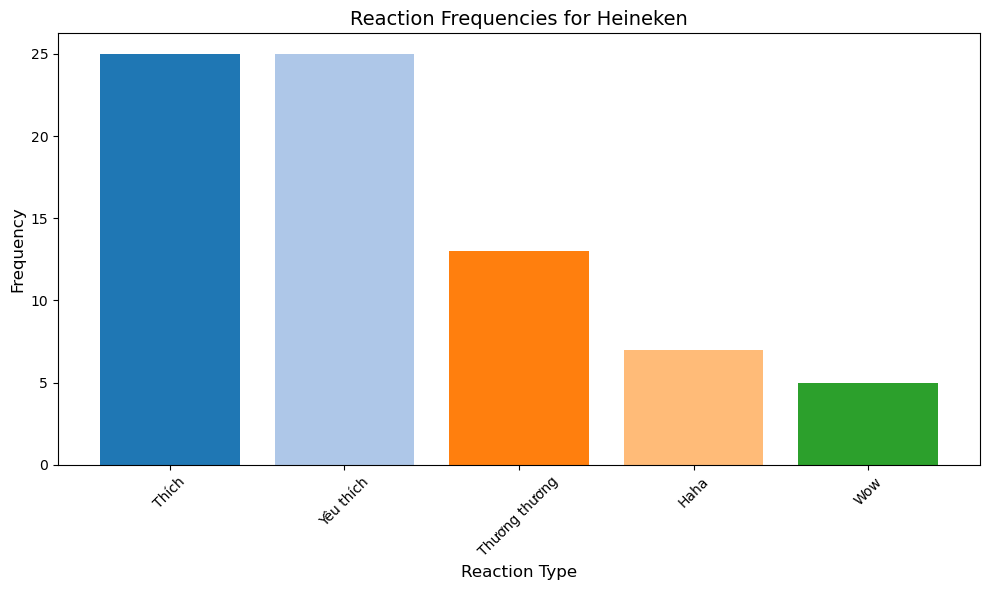


Top Reaction extraction for Beer333's posts:
{'Thích': 28, 'Yêu thích': 27, 'Thương thương': 12, 'Haha': 6, 'Wow': 3, 'Buồn': 3, 'Phẫn nộ': 1}


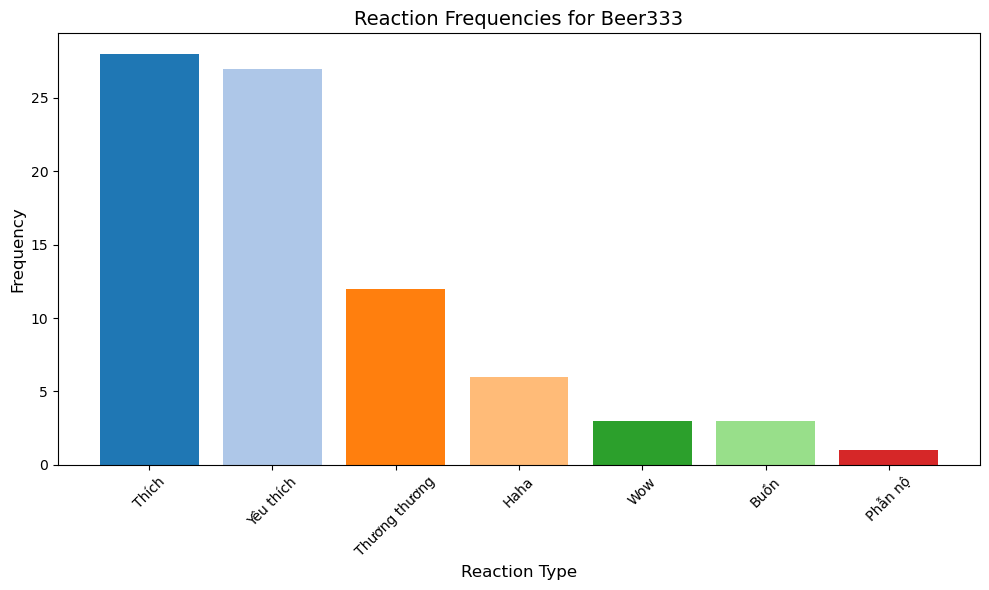


Top Reaction extraction for Biasg's posts:
{'Thích': 67, 'Yêu thích': 67, 'Thương thương': 31, 'Phẫn nộ': 12, 'Wow': 8, 'Buồn': 7, 'Haha': 6}


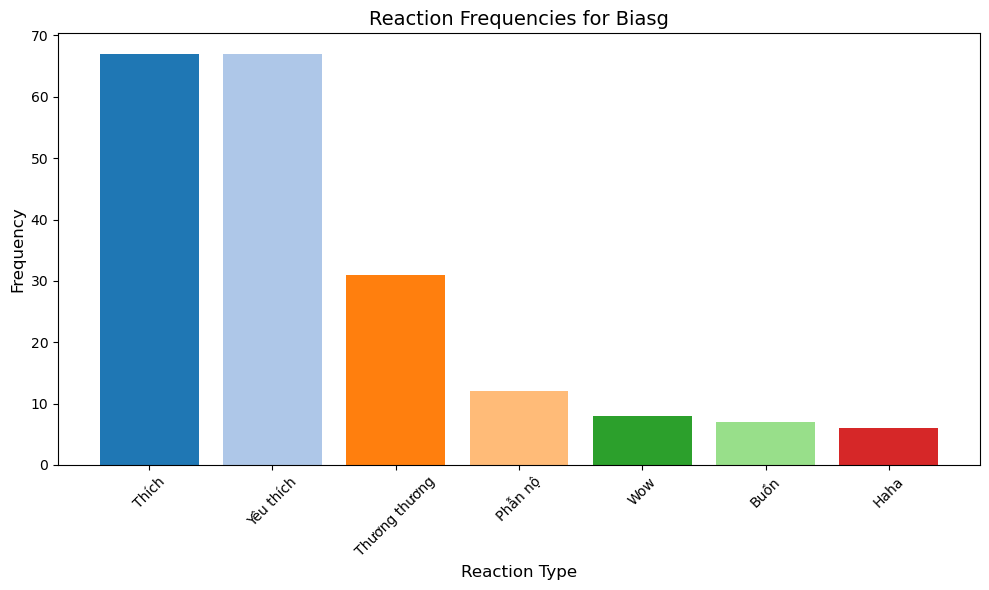

In [892]:
brands = ['heineken', 'beer333', 'biasg']

brand_dfs = {'heineken': heineken, 'beer333': beer333, 'biasg': biasg}
# Loop through each brand and process the data
for brand, df in brand_dfs.items():
    # Step 1: Split the 'top_react' column into individual reactions
    df['top_react_split'] = df['top_react'].str.replace(' và ', ', ').str.split(', ')
    
    # Step 2: Flatten the list of reactions and count frequencies
    all_reactions = df['top_react_split'].explode().value_counts().to_dict()
    
    # Print the top reactions for each brand
    print(f"\nTop Reaction extraction for {brand.capitalize()}'s posts:")
    print(all_reactions)
    df.drop(columns = 'top_react_split', inplace = True)
    # Step 3: Plot the reaction frequencies
    plt.figure(figsize=(10, 6))
    plt.bar(all_reactions.keys(), all_reactions.values(), color=plt.cm.tab20.colors)
    plt.title(f'Reaction Frequencies for {brand.capitalize()}', fontsize=14)
    plt.xlabel('Reaction Type', fontsize=12)
    plt.ylabel('Frequency', fontsize=12)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

**Analysis**

The most frequently used expressions for all three companies are **'Thích'**, **'Yêu thích'** and **'Thương thương'** This phenomenon can be attributed to these three expressions being the most popular reactions on the Facebook platform.

Analyzing Heineken's data, we observe that their posts predominantly focus on Corporate Social Responsibility (CSR) initiatives and topics related to brand and employment. Such content tends to resonate positively with viewers, thus eliciting fewer negative reactions. Conversely, for Bia Saigon, after the top three most frequent emotions, the fourth most common reaction is **'Phẫn nộ'** This can be attributed to the nature of Bia Saigon's content, which heavily features promotional and event-related posts. Disagreements among participants concerning the outcomes of events and mini-games are more likely to evoke negative sentiment which results in **'Phẫn nộ'** reactions.

In summary, the varying content strategies employed by these companies directly influence the emotional responses of their audience on social media platforms. Heineken's emphasis on CSR and brand-related topics garners more favorable reactions, while Bia Saigon's focus on promotional activities tends to provoke a higher incidence of negative reactions, particularly **'Phẫn nộ'**.

#### 4.3.3 Emojis

Emojis are crucial for analyzing the social media posts across different brands because emojis can be used to detect users sentiment (Tian and et al., 2017). By extracting unique emojis and calculating their frequencies, the analysis provides valuable insights into how each brand engages with its audience through visual language. Thus the group develops a function to extract highly used emojis per brand based on the emoji pattern.


HEINEKEN emoji summary
- Top 10 emojis for heineken: ['💚', '🔹', '💥', '🥰', '🎯', '📩', '💖', '🤩', '🤣', '💕']
- Emoji frequency for heineken: {'💚': 8, '🔹': 3, '💥': 2, '🥰': 2, '🎯': 1, '📩': 1, '💖': 1, '🤩': 1, '🤣': 1, '💕': 1}


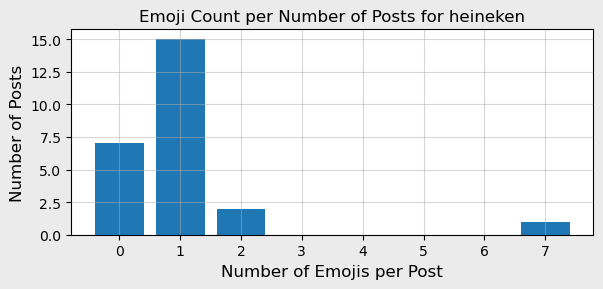


BEER333 emoji summary
- Top 10 emojis for beer333: ['👉', '🍻', '✨', '📍', '📌', '🎉', '👏', '🎁', '🙌', '🔥']
- Emoji frequency for beer333: {'👉': 10, '🍻': 8, '✨': 6, '📍': 3, '📌': 3, '🎉': 3, '👏': 3, '🎁': 2, '🙌': 2, '🔥': 1}


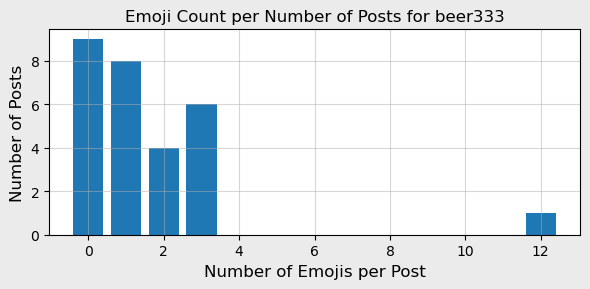


BIASG emoji summary
- Top 10 emojis for biasg: ['👉', '✨', '🎉', '🔥', '🎁', '🐉', '🍻', '🧧', '🍺', '📍']
- Emoji frequency for biasg: {'👉': 32, '✨': 23, '🎉': 14, '🔥': 11, '🎁': 10, '🐉': 10, '🍻': 10, '🧧': 9, '🍺': 7, '📍': 7}


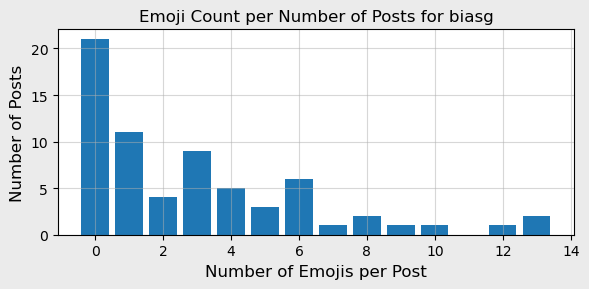

In [893]:
brands = ['heineken', 'beer333', 'biasg']

brand_dfs = {'heineken': heineken, 'beer333': beer333, 'biasg': biasg}
# Define the emoji pattern for extraction
emoji_pattern = r'[\U0001F600-\U0001F64F\U0001F300-\U0001F5FF\U0001F680-\U0001F6FF\U0001F700-\U0001F77F\U0001F780-\U0001F7FF\U0001F800-\U0001F8FF\U0001F900-\U0001F9FF\U0001FA00-\U0001FA6F\U0001FA70-\U0001FAFF\u2728]'

def extract_emoji_set(df, emoji_column):
    """
    Extracts a set of unique emojis from the specified emoji column in the DataFrame.
    """
    emojis_series = df[emoji_column].dropna()
    all_emojis = ''.join(emojis_series)
    emoji_set = set(re.findall(emoji_pattern, all_emojis))
    return emoji_set

def get_emoji_frequency(emoji_series, emoji_set):
    """
    Returns the frequency of emojis from the emoji series.
    """
    emojis = ''.join(emoji_series.dropna())
    emoji_list = [e for e in emojis if e in emoji_set]
    
    emoji_freq = {}
    for emoji_char in emoji_list:
        if emoji_char in emoji_freq:
            emoji_freq[emoji_char] += 1
        else:
            emoji_freq[emoji_char] = 1
            
    sorted_emojis = sorted(emoji_freq.items(), key=lambda item: item[1], reverse=True)
    return sorted_emojis

# Use the extracted emoji set for analysis
for brand, df in brand_dfs.items():
    print(f'\n{brand.upper()} emoji summary')
    
    # Extract emoji set and emoji frequency
    emoji_set = extract_emoji_set(df, 'emojis')
    emoji_freq = get_emoji_frequency(df['emojis'], emoji_set)
    
    # Get top 10 emojis
    top_10_emojis = dict(emoji_freq[:10])
    
    # Print top emojis and emoji frequency
    print(f'- Top 10 emojis for {brand}: {list(top_10_emojis.keys())}')
    print(f'- Emoji frequency for {brand}: {top_10_emojis}')
    
    # Calculate emoji_count per number of posts
    emoji_count_per_posts = df['emoji_count'].value_counts().sort_index()
    
    # Plot the emoji frequency
    plt.figure(facecolor='#ebebeb', figsize=(6, 3))
    plt.bar(emoji_count_per_posts.index, emoji_count_per_posts.values, color='#1f77b4')
    plt.title(f'Emoji Count per Number of Posts for {brand}', fontsize=12)
    plt.xlabel('Number of Emojis per Post', fontsize=12)
    plt.ylabel('Number of Posts', fontsize=12)
    plt.grid(alpha=0.5)
    plt.tight_layout()
    plt.show()

The trend in emoji usage across Heineken, Bia Saigon, and the third unnamed company shows a consistent pattern, with the majority of posts containing at least one emoji. Posts devoid of emojis are predominantly classified as 'Appearance and Setting Posts,' which logically explains the absence of emojis in such content. These posts typically focus on the visual aspects and settings without the need for the expressive or engaging elements that emojis provide.

For Heineken, the most frequently used emojis include '💚', '🔹', '💥', '🍻', '🥰', '🎯', '📩', '💖', '💛' and '💙'. These emojis are strategically employed to foster empathy and engagement with viewers. Heineken's posts predominantly focus on Corporate Social Responsibility (CSR) initiatives and topics related to brand image and employment opportunities. The use of emojis like '💚' and '🍻' and other emojis that specify positive expression highlights their connection to brand idenitiy, sustainability and celebration, which resonates well with their audience.

In the case of Saigon Beer, the commonly used emojis are '👉', '✨', '🎉', '🍻', '🍺', '🎁', '🔥', '🐉', '📍', and '🧧'. These emojis are indicative of events or mini-games, aligning with the primary content of Bia Saigon's posts, which often center around interactive and festive activities. The '👉' emoji is used to direct attention, while '✨' and '🎉' convey excitement and celebration. Emojis like '🍻' and '🍺' are directly related to their product, enhancing brand recognition and customer engagement. The use of '🔥' and '🐉' reflects cultural elements and thematic events, making the content more relatable to the local audience. Additionally, '📍' and '🧧' indicate specific locations and cultural symbols, which are crucial for engaging with their target demographic.


#### 4.3.4. Hashtags

By generating word clouds, the analysis provides a clear and engaging way to identify the most frequently used hashtags, which can reveal trends in marketing strategies and audience interests. Understanding which hashtags are prevalent allows brands to refine their social media strategies, ensuring they align with current conversations and topics that resonate with their target audience. Moreover, word clouds serve as a compelling visual tool that can be easily interpreted, making it easier for stakeholders to grasp the core themes in the brands’ messaging. The group create a function to visualize the most-used hashtags of 3 brands:

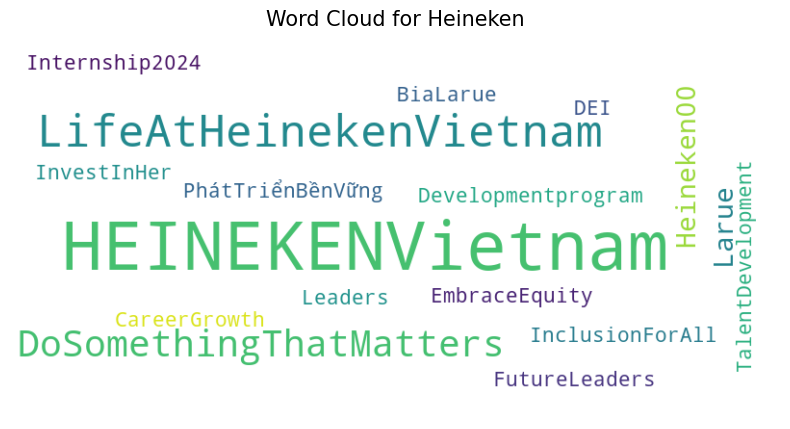

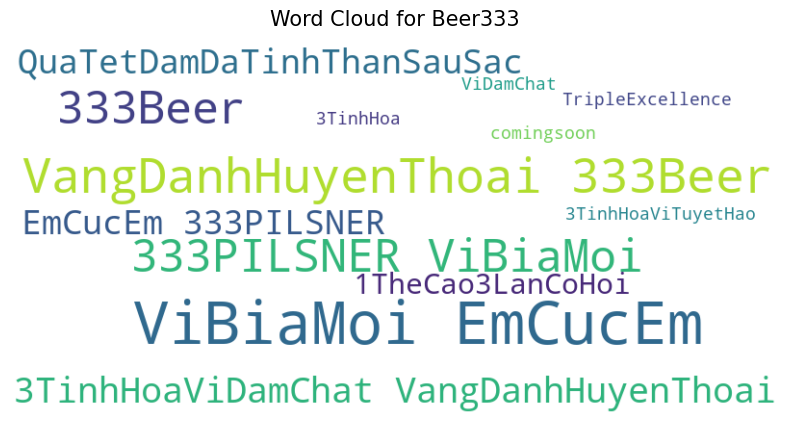

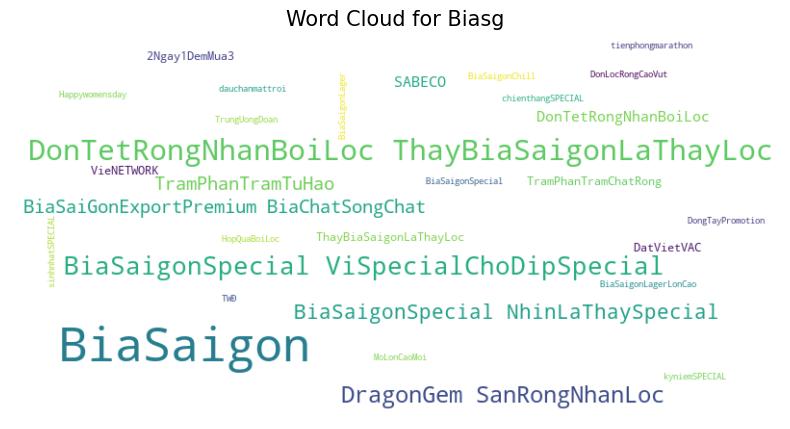

In [894]:
brands = ['heineken', 'beer333', 'biasg']

brand_dfs = {'heineken': heineken, 'beer333': beer333, 'biasg': biasg}
from wordcloud import WordCloud
def generate_wordcloud(text, brand):
    """
    Generate and display a word cloud for the given text.
    
    Parameters:
    - text: str, text for generating the word cloud
    - brand: str, brand name for the title
    """
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)
    
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(f'Word Cloud for {brand.capitalize()}', fontsize=15)
    plt.show()

def get_hashtag_text(df):
    """
    Combine all hashtags into a single string.
    
    Parameters:
    - df: pd.DataFrame containing the data
    
    Returns:
    - str, combined hashtags text
    """
    hashtags_series = df['hashtags'].dropna()
    hashtags_list = [hashtag for sublist in hashtags_series for hashtag in sublist]
    return ' '.join(hashtags_list)

# Generate word clouds for each brand
for brand, df in brand_dfs.items():
    hashtags_text = get_hashtag_text(df)
    generate_wordcloud(hashtags_text, brand)


**Function:**

The function generates word clouds based on hashtags from social media posts for various brands, visually representing word frequency with larger words indicating higher usage. It combines all hashtags from each brand's posts into a single string, then creates and displays a word cloud for each brand using the 'WordCloud' library. This provides a clear visual of the most common hashtags used by each brand, offering insights into their marketing focus and audience engagement.

**Results:**

The hashtags employed by Heineken, 333 Beer, and Saigon Beer on their fanpages provide a valuable window into the marketing strategies and thematic priorities of each brand. By examining the frequency and prominence of these hashtags, we can discern the core content and engagement approaches utilized by these companies to resonate with their respective audiences.
Heineken’s hashtag strategy is notably community-focused, reflecting the brand’s commitment to Corporate Social Responsibility (CSR), brand image enhancement, and employment opportunities. Frequently used hashtags such as 'HeinekenVietnam', 'LifeatHEINEKENVietnam',' PhatTrienBenVung', and 'DoSomethingThatMatters' suggest that Heineken aims to position itself as a socially responsible and community-oriented brand. These hashtags indicate that Heineken’s content strategy is centered around initiatives that contribute to societal well-being, environmental sustainability, and the overall betterment of the community. This approach not only enhances Heineken's brand image but also fosters a sense of corporate ethics and responsibility, appealing to socially conscious consumers.
On the other hand, Saigon Beer and 333 Beer adopt a different approach, as evidenced by their prominent hashtags. Tags such as '1TheCao3LanCoHoi', 'QuaTetDamDaTinhThanSauSac','ThayBiaSaigonLaThayLoc','DonTetRongNhanBoiLoc', and 'VípecialChoDipSpecial' underscore a marketing strategy heavily focused on promotions and event-driven content. These hashtags suggest that the primary aim of Saigon Beer and 333 Beer  is to engage consumers through special offers, festive promotions, and celebratory events. By leveraging culturally significant occasions and promotions, these brands are able to create a buzz and drive consumer participation and loyalty. This strategy is particularly effective in markets where festive and promotional events play a crucial role in consumer purchasing decisions.
The content differentiation between Heineken and the other two brands is significant. Heineken’s focus on CSR and community-related content sets it apart as a brand that not only sells products but also invests in the community’s well-being. This can enhance brand loyalty among consumers who value ethical and responsible business practices. In contrast, Saigon Beer and 333 Beer’s emphasis on promotional content appeals to consumers who are motivated by deals, special offers, and the festive spirit. Heineken’s strategy might attract a demographic that is interested in sustainable practices and corporate ethics, while Saigon Beer and 333 Beer’s approach is likely to appeal to a more diverse consumer base interested in immediate value and festive engagement. 
